In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Dec 29 19:06:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   41C    P8    40W / 250W |   6474MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 41%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 1000

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '29December_Tracks_to_Hists_Iteration_4B_1000epochs_lr_2em7_2p5_kde2hists_allFloat'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 2e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 27.26 s
outer loop X.shape =  (20000, 9, 600)
Constructing 18000 event dataset took 0.09099 s
x_t.shape =  torch.Size([18000, 9, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  9
x_t.shape =  torch.Size([18000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '29December_Tracks_to_Hists_Iteration_3B_300epochs_lr_2em7_2p5_kde2hists_allFloat'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


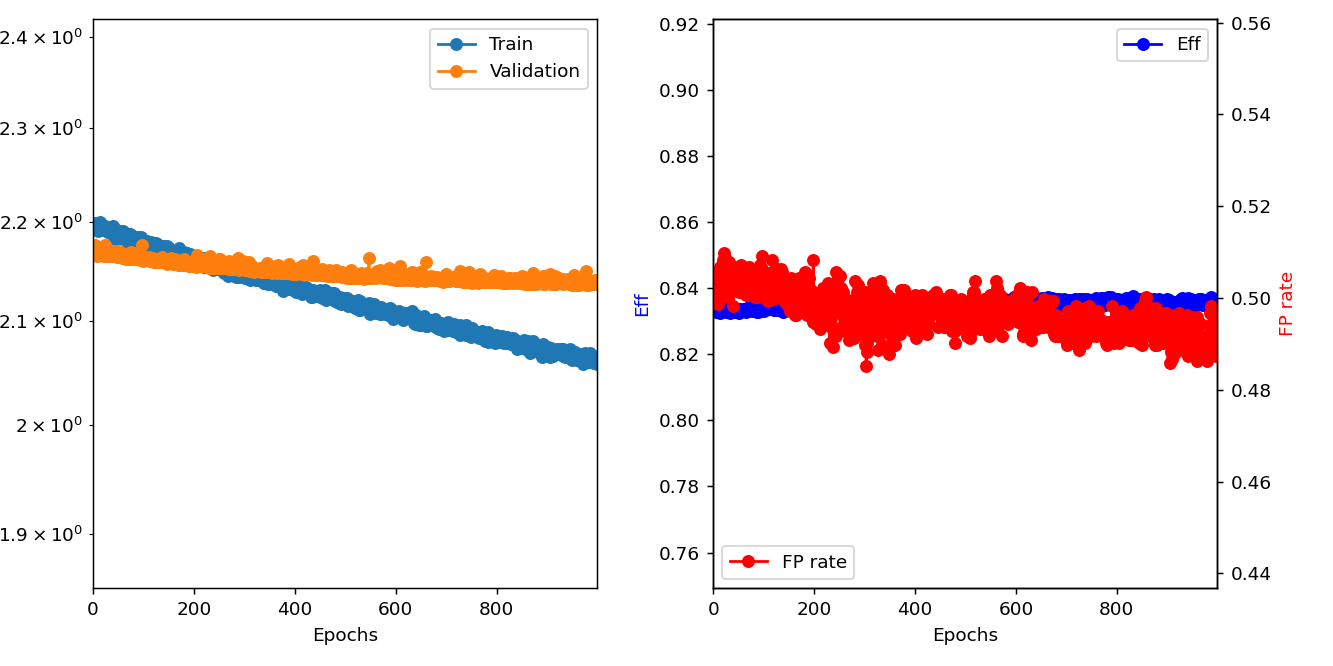

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Epoch 0: train=2.19754, val=2.16612, took 45.3 s
  Validation Found 9016 of 10819, added 1004 (eff 83.33%) (0.502 FP/event)


Epoch 1: train=2.19612, val=2.16843, took 43.483 s
  Validation Found 9023 of 10819, added 1000 (eff 83.40%) (0.5 FP/event)


Epoch 2: train=2.19632, val=2.17279, took 43.841 s
  Validation Found 9021 of 10819, added 1003 (eff 83.38%) (0.501 FP/event)


Epoch 3: train=2.19567, val=2.176, took 44.083 s
  Validation Found 9019 of 10819, added 1002 (eff 83.36%) (0.501 FP/event)


Epoch 4: train=2.19876, val=2.17194, took 44.258 s
  Validation Found 9015 of 10819, added 1004 (eff 83.33%) (0.502 FP/event)


Epoch 5: train=2.19652, val=2.16721, took 44.093 s
  Validation Found 9011 of 10819, added 1012 (eff 83.29%) (0.506 FP/event)


Epoch 6: train=2.19482, val=2.16817, took 44.196 s
  Validation Found 9014 of 10819, added 1009 (eff 83.32%) (0.504 FP/event)


Epoch 7: train=2.19426, val=2.16746, took 44.197 s
  Validation Found 9018 of 10819, added 1003 (eff 83.35%) (0.501 FP/event)


Epoch 8: train=2.19623, val=2.16561, took 44.098 s
  Validation Found 9014 of 10819, added 1001 (eff 83.32%) (0.5 FP/event)


Epoch 9: train=2.19045, val=2.16955, took 44.226 s
  Validation Found 9012 of 10819, added 998 (eff 83.30%) (0.499 FP/event)


Epoch 10: train=2.19326, val=2.16707, took 44.27 s
  Validation Found 9015 of 10819, added 1012 (eff 83.33%) (0.506 FP/event)


Epoch 11: train=2.19604, val=2.1661, took 44.331 s
  Validation Found 9013 of 10819, added 1006 (eff 83.31%) (0.503 FP/event)


Epoch 12: train=2.19156, val=2.16773, took 44.3 s
  Validation Found 9010 of 10819, added 1012 (eff 83.28%) (0.506 FP/event)


Epoch 13: train=2.2001, val=2.16793, took 44.23 s
  Validation Found 9008 of 10819, added 1014 (eff 83.26%) (0.507 FP/event)


Epoch 14: train=2.19602, val=2.1674, took 44.304 s
  Validation Found 9016 of 10819, added 1004 (eff 83.33%) (0.502 FP/event)


Epoch 15: train=2.19529, val=2.16666, took 44.225 s
  Validation Found 9009 of 10819, added 1009 (eff 83.27%) (0.504 FP/event)


Epoch 16: train=2.1976, val=2.16598, took 44.196 s
  Validation Found 9012 of 10819, added 1010 (eff 83.30%) (0.505 FP/event)


Epoch 17: train=2.19399, val=2.16581, took 44.319 s
  Validation Found 9014 of 10819, added 1010 (eff 83.32%) (0.505 FP/event)


Epoch 18: train=2.19183, val=2.1705, took 44.151 s
  Validation Found 9018 of 10819, added 1007 (eff 83.35%) (0.503 FP/event)


Epoch 19: train=2.19333, val=2.17025, took 44.073 s
  Validation Found 9014 of 10819, added 1017 (eff 83.32%) (0.508 FP/event)


Epoch 20: train=2.19389, val=2.1675, took 44.336 s
  Validation Found 9022 of 10819, added 1010 (eff 83.39%) (0.505 FP/event)


Epoch 21: train=2.19143, val=2.16674, took 44.135 s
  Validation Found 9016 of 10819, added 1012 (eff 83.33%) (0.506 FP/event)


Epoch 22: train=2.19304, val=2.16554, took 44.124 s
  Validation Found 9022 of 10819, added 1020 (eff 83.39%) (0.51 FP/event)


Epoch 23: train=2.19581, val=2.16671, took 44.1 s
  Validation Found 9019 of 10819, added 1018 (eff 83.36%) (0.509 FP/event)


Epoch 24: train=2.19165, val=2.17661, took 44.149 s
  Validation Found 9012 of 10819, added 1014 (eff 83.30%) (0.507 FP/event)


Epoch 25: train=2.19415, val=2.16602, took 44.115 s
  Validation Found 9025 of 10819, added 1011 (eff 83.42%) (0.505 FP/event)


Epoch 26: train=2.19138, val=2.16931, took 44.158 s
  Validation Found 9014 of 10819, added 1005 (eff 83.32%) (0.502 FP/event)


Epoch 27: train=2.19432, val=2.16503, took 44.26 s
  Validation Found 9011 of 10819, added 1001 (eff 83.29%) (0.5 FP/event)


Epoch 28: train=2.19086, val=2.16518, took 44.123 s
  Validation Found 9009 of 10819, added 1006 (eff 83.27%) (0.503 FP/event)


Epoch 29: train=2.18989, val=2.16562, took 44.15 s
  Validation Found 9021 of 10819, added 1011 (eff 83.38%) (0.505 FP/event)


Epoch 30: train=2.19069, val=2.16553, took 43.981 s
  Validation Found 9016 of 10819, added 1015 (eff 83.33%) (0.507 FP/event)


Epoch 31: train=2.19113, val=2.16619, took 43.696 s
  Validation Found 9020 of 10819, added 1016 (eff 83.37%) (0.508 FP/event)


Epoch 32: train=2.19467, val=2.16575, took 44.081 s
  Validation Found 9019 of 10819, added 1015 (eff 83.36%) (0.507 FP/event)


Epoch 33: train=2.18888, val=2.16878, took 44.06 s
  Validation Found 9007 of 10819, added 1008 (eff 83.25%) (0.504 FP/event)


Epoch 34: train=2.19197, val=2.16628, took 43.964 s
  Validation Found 9016 of 10819, added 1008 (eff 83.33%) (0.504 FP/event)


Epoch 35: train=2.18993, val=2.16757, took 43.924 s
  Validation Found 9017 of 10819, added 1010 (eff 83.34%) (0.505 FP/event)


Epoch 36: train=2.19241, val=2.16559, took 44.212 s
  Validation Found 9024 of 10819, added 1005 (eff 83.41%) (0.502 FP/event)


Epoch 37: train=2.18971, val=2.16537, took 44.199 s
  Validation Found 9021 of 10819, added 1006 (eff 83.38%) (0.503 FP/event)


Epoch 38: train=2.19032, val=2.16688, took 44.31 s
  Validation Found 9020 of 10819, added 1006 (eff 83.37%) (0.503 FP/event)


Epoch 39: train=2.19553, val=2.1672, took 44.027 s
  Validation Found 9011 of 10819, added 1006 (eff 83.29%) (0.503 FP/event)


Epoch 40: train=2.19328, val=2.16903, took 43.991 s
  Validation Found 9010 of 10819, added 997 (eff 83.28%) (0.498 FP/event)


Epoch 41: train=2.19402, val=2.17066, took 43.817 s
  Validation Found 9017 of 10819, added 1009 (eff 83.34%) (0.504 FP/event)


Epoch 42: train=2.19079, val=2.1666, took 43.686 s
  Validation Found 9016 of 10819, added 1010 (eff 83.33%) (0.505 FP/event)


Epoch 43: train=2.19134, val=2.16614, took 43.752 s
  Validation Found 9010 of 10819, added 1012 (eff 83.28%) (0.506 FP/event)


Epoch 44: train=2.18248, val=2.16534, took 44.117 s
  Validation Found 9011 of 10819, added 1006 (eff 83.29%) (0.503 FP/event)


Epoch 45: train=2.19153, val=2.16622, took 44.133 s
  Validation Found 9011 of 10819, added 1006 (eff 83.29%) (0.503 FP/event)


Epoch 46: train=2.18767, val=2.16783, took 44.004 s
  Validation Found 9021 of 10819, added 1009 (eff 83.38%) (0.504 FP/event)


Epoch 47: train=2.18584, val=2.16699, took 44.082 s
  Validation Found 9010 of 10819, added 1006 (eff 83.28%) (0.503 FP/event)


Epoch 48: train=2.19004, val=2.1645, took 44.196 s
  Validation Found 9012 of 10819, added 1014 (eff 83.30%) (0.507 FP/event)


Epoch 49: train=2.18855, val=2.16566, took 43.823 s
  Validation Found 9020 of 10819, added 1012 (eff 83.37%) (0.506 FP/event)


Epoch 50: train=2.18575, val=2.16473, took 44.036 s
  Validation Found 9020 of 10819, added 1003 (eff 83.37%) (0.501 FP/event)


Epoch 51: train=2.18469, val=2.16982, took 44.3 s
  Validation Found 9006 of 10819, added 1005 (eff 83.24%) (0.502 FP/event)


Epoch 52: train=2.19123, val=2.16506, took 44.13 s
  Validation Found 9018 of 10819, added 1006 (eff 83.35%) (0.503 FP/event)


Epoch 53: train=2.18442, val=2.16765, took 43.857 s
  Validation Found 9014 of 10819, added 1006 (eff 83.32%) (0.503 FP/event)


Epoch 54: train=2.18365, val=2.16457, took 44.1 s
  Validation Found 9013 of 10819, added 1012 (eff 83.31%) (0.506 FP/event)


Epoch 55: train=2.19125, val=2.16468, took 44.238 s
  Validation Found 9013 of 10819, added 1015 (eff 83.31%) (0.507 FP/event)


Epoch 56: train=2.1876, val=2.16421, took 44.325 s
  Validation Found 9020 of 10819, added 1009 (eff 83.37%) (0.504 FP/event)


Epoch 57: train=2.18413, val=2.16568, took 44.24 s
  Validation Found 9014 of 10819, added 1006 (eff 83.32%) (0.503 FP/event)


Epoch 58: train=2.19009, val=2.16429, took 44.046 s
  Validation Found 9013 of 10819, added 1014 (eff 83.31%) (0.507 FP/event)


Epoch 59: train=2.1842, val=2.1628, took 44.29 s
  Validation Found 9019 of 10819, added 1006 (eff 83.36%) (0.503 FP/event)


Epoch 60: train=2.19083, val=2.16329, took 44.026 s
  Validation Found 9016 of 10819, added 1006 (eff 83.33%) (0.503 FP/event)


Epoch 61: train=2.1877, val=2.16329, took 44.147 s
  Validation Found 9016 of 10819, added 1008 (eff 83.33%) (0.504 FP/event)


Epoch 62: train=2.18493, val=2.1641, took 44.14 s
  Validation Found 9018 of 10819, added 1008 (eff 83.35%) (0.504 FP/event)


Epoch 63: train=2.18892, val=2.16279, took 44.187 s
  Validation Found 9012 of 10819, added 1012 (eff 83.30%) (0.506 FP/event)


Epoch 64: train=2.18609, val=2.16272, took 44.174 s
  Validation Found 9010 of 10819, added 1005 (eff 83.28%) (0.502 FP/event)


Epoch 65: train=2.186, val=2.16673, took 44.049 s
  Validation Found 9016 of 10819, added 1002 (eff 83.33%) (0.501 FP/event)


Epoch 66: train=2.18426, val=2.16244, took 43.866 s
  Validation Found 9023 of 10819, added 1010 (eff 83.40%) (0.505 FP/event)


Epoch 67: train=2.1794, val=2.16295, took 44.061 s
  Validation Found 9020 of 10819, added 1009 (eff 83.37%) (0.504 FP/event)


Epoch 68: train=2.1867, val=2.16288, took 44.096 s
  Validation Found 9020 of 10819, added 1009 (eff 83.37%) (0.504 FP/event)


Epoch 69: train=2.18765, val=2.1664, took 43.975 s
  Validation Found 9016 of 10819, added 1002 (eff 83.33%) (0.501 FP/event)


Epoch 70: train=2.18765, val=2.16333, took 44.27 s
  Validation Found 9021 of 10819, added 1014 (eff 83.38%) (0.507 FP/event)


Epoch 71: train=2.18806, val=2.16774, took 44.372 s
  Validation Found 9016 of 10819, added 1007 (eff 83.33%) (0.503 FP/event)


Epoch 72: train=2.18649, val=2.16236, took 44.125 s
  Validation Found 9025 of 10819, added 1011 (eff 83.42%) (0.505 FP/event)


Epoch 73: train=2.18785, val=2.16246, took 44.021 s
  Validation Found 9026 of 10819, added 1004 (eff 83.43%) (0.502 FP/event)


Epoch 74: train=2.18404, val=2.1638, took 44.084 s
  Validation Found 9026 of 10819, added 1002 (eff 83.43%) (0.501 FP/event)


Epoch 75: train=2.1791, val=2.16273, took 44.245 s
  Validation Found 9026 of 10819, added 1005 (eff 83.43%) (0.502 FP/event)


Epoch 76: train=2.18623, val=2.1694, took 44.141 s
  Validation Found 9014 of 10819, added 1005 (eff 83.32%) (0.502 FP/event)


Epoch 77: train=2.18056, val=2.16602, took 44.107 s
  Validation Found 9016 of 10819, added 1003 (eff 83.33%) (0.501 FP/event)


Epoch 78: train=2.18274, val=2.16289, took 43.802 s
  Validation Found 9025 of 10819, added 1004 (eff 83.42%) (0.502 FP/event)


Epoch 79: train=2.18339, val=2.16612, took 44.044 s
  Validation Found 9018 of 10819, added 1011 (eff 83.35%) (0.505 FP/event)


Epoch 80: train=2.17966, val=2.16336, took 44.03 s
  Validation Found 9028 of 10819, added 1002 (eff 83.45%) (0.501 FP/event)


Epoch 81: train=2.18221, val=2.16866, took 44.03 s
  Validation Found 9018 of 10819, added 1002 (eff 83.35%) (0.501 FP/event)


Epoch 82: train=2.18247, val=2.16262, took 44.156 s
  Validation Found 9018 of 10819, added 1004 (eff 83.35%) (0.502 FP/event)


Epoch 83: train=2.18185, val=2.16423, took 44.256 s
  Validation Found 9020 of 10819, added 1001 (eff 83.37%) (0.5 FP/event)


Epoch 84: train=2.17906, val=2.16614, took 44.082 s
  Validation Found 9017 of 10819, added 1002 (eff 83.34%) (0.501 FP/event)


Epoch 85: train=2.18148, val=2.16573, took 44.159 s
  Validation Found 9016 of 10819, added 1003 (eff 83.33%) (0.501 FP/event)


Epoch 86: train=2.18482, val=2.16244, took 44.049 s
  Validation Found 9018 of 10819, added 1008 (eff 83.35%) (0.504 FP/event)


Epoch 87: train=2.17959, val=2.1624, took 44.183 s
  Validation Found 9010 of 10819, added 1001 (eff 83.28%) (0.5 FP/event)


Epoch 88: train=2.18105, val=2.16242, took 43.963 s
  Validation Found 9016 of 10819, added 1008 (eff 83.33%) (0.504 FP/event)


Epoch 89: train=2.17915, val=2.16181, took 44.003 s
  Validation Found 9010 of 10819, added 1005 (eff 83.28%) (0.502 FP/event)


Epoch 90: train=2.17956, val=2.16231, took 44.047 s
  Validation Found 9012 of 10819, added 1009 (eff 83.30%) (0.504 FP/event)


Epoch 91: train=2.18057, val=2.16486, took 44.083 s
  Validation Found 9015 of 10819, added 1011 (eff 83.33%) (0.505 FP/event)


Epoch 92: train=2.18418, val=2.16422, took 44.018 s
  Validation Found 9022 of 10819, added 1006 (eff 83.39%) (0.503 FP/event)


Epoch 93: train=2.17681, val=2.16141, took 44.084 s
  Validation Found 9021 of 10819, added 1015 (eff 83.38%) (0.507 FP/event)


Epoch 94: train=2.17723, val=2.16643, took 44.039 s
  Validation Found 9023 of 10819, added 1005 (eff 83.40%) (0.502 FP/event)


Epoch 95: train=2.18486, val=2.16402, took 44.028 s
  Validation Found 9018 of 10819, added 1012 (eff 83.35%) (0.506 FP/event)


Epoch 96: train=2.18076, val=2.16607, took 43.985 s
  Validation Found 9022 of 10819, added 1013 (eff 83.39%) (0.506 FP/event)


Epoch 97: train=2.18157, val=2.16185, took 44.055 s
  Validation Found 9022 of 10819, added 1019 (eff 83.39%) (0.509 FP/event)


Epoch 98: train=2.1803, val=2.17676, took 43.711 s
  Validation Found 9020 of 10819, added 1012 (eff 83.37%) (0.506 FP/event)


Epoch 99: train=2.17936, val=2.16054, took 43.929 s
  Validation Found 9017 of 10819, added 1012 (eff 83.34%) (0.506 FP/event)


Epoch 100: train=2.18066, val=2.1618, took 44.009 s
  Validation Found 9027 of 10819, added 1006 (eff 83.44%) (0.503 FP/event)


Epoch 101: train=2.17698, val=2.16113, took 44.148 s
  Validation Found 9012 of 10819, added 1002 (eff 83.30%) (0.501 FP/event)


Epoch 102: train=2.17403, val=2.16096, took 44.041 s
  Validation Found 9020 of 10819, added 1010 (eff 83.37%) (0.505 FP/event)


Epoch 103: train=2.17506, val=2.16067, took 43.714 s
  Validation Found 9025 of 10819, added 1006 (eff 83.42%) (0.503 FP/event)


Epoch 104: train=2.17634, val=2.1624, took 44.249 s
  Validation Found 9030 of 10819, added 1000 (eff 83.46%) (0.5 FP/event)


Epoch 105: train=2.17842, val=2.16094, took 43.889 s
  Validation Found 9028 of 10819, added 1006 (eff 83.45%) (0.503 FP/event)


Epoch 106: train=2.18009, val=2.16211, took 43.875 s
  Validation Found 9028 of 10819, added 1011 (eff 83.45%) (0.505 FP/event)


Epoch 107: train=2.17621, val=2.16076, took 43.711 s
  Validation Found 9028 of 10819, added 1009 (eff 83.45%) (0.504 FP/event)


Epoch 108: train=2.17862, val=2.16179, took 43.97 s
  Validation Found 9024 of 10819, added 1009 (eff 83.41%) (0.504 FP/event)


Epoch 109: train=2.1769, val=2.16354, took 43.94 s
  Validation Found 9029 of 10819, added 999 (eff 83.46%) (0.499 FP/event)


Epoch 110: train=2.17807, val=2.16386, took 44.12 s
  Validation Found 9020 of 10819, added 1008 (eff 83.37%) (0.504 FP/event)


Epoch 111: train=2.17611, val=2.16155, took 44.1 s
  Validation Found 9025 of 10819, added 1004 (eff 83.42%) (0.502 FP/event)


Epoch 112: train=2.17811, val=2.16034, took 43.949 s
  Validation Found 9027 of 10819, added 1003 (eff 83.44%) (0.501 FP/event)


Epoch 113: train=2.17867, val=2.16255, took 44.224 s
  Validation Found 9024 of 10819, added 1011 (eff 83.41%) (0.505 FP/event)


Epoch 114: train=2.17898, val=2.16029, took 44.183 s
  Validation Found 9035 of 10819, added 1004 (eff 83.51%) (0.502 FP/event)


Epoch 115: train=2.17733, val=2.16108, took 43.899 s
  Validation Found 9025 of 10819, added 1005 (eff 83.42%) (0.502 FP/event)


Epoch 116: train=2.17076, val=2.16226, took 44.134 s
  Validation Found 9032 of 10819, added 1012 (eff 83.48%) (0.506 FP/event)


Epoch 117: train=2.17689, val=2.16054, took 44.191 s
  Validation Found 9019 of 10819, added 1017 (eff 83.36%) (0.508 FP/event)


Epoch 118: train=2.17766, val=2.1612, took 43.989 s
  Validation Found 9030 of 10819, added 1000 (eff 83.46%) (0.5 FP/event)


Epoch 119: train=2.17288, val=2.16364, took 43.737 s
  Validation Found 9028 of 10819, added 1008 (eff 83.45%) (0.504 FP/event)


Epoch 120: train=2.17555, val=2.1609, took 44.201 s
  Validation Found 9015 of 10819, added 1011 (eff 83.33%) (0.505 FP/event)


Epoch 121: train=2.17647, val=2.15958, took 44.166 s
  Validation Found 9019 of 10819, added 1006 (eff 83.36%) (0.503 FP/event)


Epoch 122: train=2.17624, val=2.15989, took 44.13 s
  Validation Found 9017 of 10819, added 1006 (eff 83.34%) (0.503 FP/event)


Epoch 123: train=2.17307, val=2.1592, took 44.099 s
  Validation Found 9028 of 10819, added 1004 (eff 83.45%) (0.502 FP/event)


Epoch 124: train=2.17847, val=2.16006, took 44.036 s
  Validation Found 9021 of 10819, added 1007 (eff 83.38%) (0.503 FP/event)


Epoch 125: train=2.17411, val=2.15945, took 44.155 s
  Validation Found 9029 of 10819, added 1009 (eff 83.46%) (0.504 FP/event)


Epoch 126: train=2.17767, val=2.16031, took 44.063 s
  Validation Found 9026 of 10819, added 1013 (eff 83.43%) (0.506 FP/event)


Epoch 127: train=2.17614, val=2.16026, took 44.201 s
  Validation Found 9028 of 10819, added 1004 (eff 83.45%) (0.502 FP/event)


Epoch 128: train=2.1732, val=2.15975, took 44.063 s
  Validation Found 9021 of 10819, added 1008 (eff 83.38%) (0.504 FP/event)


Epoch 129: train=2.17619, val=2.16075, took 44.249 s
  Validation Found 9015 of 10819, added 1005 (eff 83.33%) (0.502 FP/event)


Epoch 130: train=2.17371, val=2.16095, took 44.079 s
  Validation Found 9022 of 10819, added 1011 (eff 83.39%) (0.505 FP/event)


Epoch 131: train=2.17317, val=2.16012, took 43.96 s
  Validation Found 9028 of 10819, added 1002 (eff 83.45%) (0.501 FP/event)


Epoch 132: train=2.1732, val=2.15903, took 43.848 s
  Validation Found 9020 of 10819, added 1005 (eff 83.37%) (0.502 FP/event)


Epoch 133: train=2.16908, val=2.1601, took 44.094 s
  Validation Found 9038 of 10819, added 1008 (eff 83.54%) (0.504 FP/event)


Epoch 134: train=2.1727, val=2.15909, took 44.191 s
  Validation Found 9026 of 10819, added 1008 (eff 83.43%) (0.504 FP/event)


Epoch 135: train=2.17379, val=2.15946, took 44.228 s
  Validation Found 9026 of 10819, added 1013 (eff 83.43%) (0.506 FP/event)


Epoch 136: train=2.17202, val=2.16437, took 44.091 s
  Validation Found 9016 of 10819, added 1007 (eff 83.33%) (0.503 FP/event)


Epoch 137: train=2.17088, val=2.15895, took 44.258 s
  Validation Found 9031 of 10819, added 1012 (eff 83.47%) (0.506 FP/event)


Epoch 138: train=2.17555, val=2.16104, took 44.031 s
  Validation Found 9010 of 10819, added 1006 (eff 83.28%) (0.503 FP/event)


Epoch 139: train=2.17511, val=2.16008, took 44.14 s
  Validation Found 9034 of 10819, added 1009 (eff 83.50%) (0.504 FP/event)


Epoch 140: train=2.17357, val=2.16001, took 44.165 s
  Validation Found 9025 of 10819, added 999 (eff 83.42%) (0.499 FP/event)


Epoch 141: train=2.17322, val=2.15916, took 44.108 s
  Validation Found 9024 of 10819, added 1003 (eff 83.41%) (0.501 FP/event)


Epoch 142: train=2.16911, val=2.16135, took 44.021 s
  Validation Found 9017 of 10819, added 1001 (eff 83.34%) (0.5 FP/event)


Epoch 143: train=2.17013, val=2.1591, took 43.946 s
  Validation Found 9027 of 10819, added 1003 (eff 83.44%) (0.501 FP/event)


Epoch 144: train=2.17129, val=2.15803, took 43.8 s
  Validation Found 9034 of 10819, added 1003 (eff 83.50%) (0.501 FP/event)


Epoch 145: train=2.17309, val=2.15769, took 44.154 s
  Validation Found 9028 of 10819, added 1003 (eff 83.45%) (0.501 FP/event)


Epoch 146: train=2.17532, val=2.15745, took 44.126 s
  Validation Found 9028 of 10819, added 1005 (eff 83.45%) (0.502 FP/event)


Epoch 147: train=2.16824, val=2.15811, took 44.115 s
  Validation Found 9021 of 10819, added 998 (eff 83.38%) (0.499 FP/event)


Epoch 148: train=2.17412, val=2.15824, took 44.194 s
  Validation Found 9020 of 10819, added 1002 (eff 83.37%) (0.501 FP/event)


Epoch 149: train=2.17137, val=2.16131, took 44.233 s
  Validation Found 9027 of 10819, added 999 (eff 83.44%) (0.499 FP/event)


Epoch 150: train=2.17213, val=2.15791, took 44.118 s
  Validation Found 9025 of 10819, added 1008 (eff 83.42%) (0.504 FP/event)


Epoch 151: train=2.17021, val=2.15885, took 44.218 s
  Validation Found 9021 of 10819, added 1001 (eff 83.38%) (0.5 FP/event)


Epoch 152: train=2.16713, val=2.15864, took 44.134 s
  Validation Found 9018 of 10819, added 995 (eff 83.35%) (0.497 FP/event)


Epoch 153: train=2.16989, val=2.15824, took 44.089 s
  Validation Found 9026 of 10819, added 1002 (eff 83.43%) (0.501 FP/event)


Epoch 154: train=2.16964, val=2.1578, took 44.105 s
  Validation Found 9026 of 10819, added 1003 (eff 83.43%) (0.501 FP/event)


Epoch 155: train=2.16517, val=2.16325, took 44.168 s
  Validation Found 9027 of 10819, added 1009 (eff 83.44%) (0.504 FP/event)


Epoch 156: train=2.16833, val=2.15756, took 44.123 s
  Validation Found 9023 of 10819, added 997 (eff 83.40%) (0.498 FP/event)


Epoch 157: train=2.16761, val=2.15837, took 44.19 s
  Validation Found 9022 of 10819, added 1001 (eff 83.39%) (0.5 FP/event)


Epoch 158: train=2.17027, val=2.15925, took 44.194 s
  Validation Found 9023 of 10819, added 1002 (eff 83.40%) (0.501 FP/event)


Epoch 159: train=2.17067, val=2.1575, took 44.096 s
  Validation Found 9029 of 10819, added 998 (eff 83.46%) (0.499 FP/event)


Epoch 160: train=2.16991, val=2.15777, took 44.371 s
  Validation Found 9024 of 10819, added 1001 (eff 83.41%) (0.5 FP/event)


Epoch 161: train=2.17029, val=2.157, took 44.203 s
  Validation Found 9017 of 10819, added 993 (eff 83.34%) (0.496 FP/event)


Epoch 162: train=2.16979, val=2.16199, took 44.103 s
  Validation Found 9027 of 10819, added 1007 (eff 83.44%) (0.503 FP/event)


Epoch 163: train=2.16088, val=2.15921, took 44.184 s
  Validation Found 9015 of 10819, added 997 (eff 83.33%) (0.498 FP/event)


Epoch 164: train=2.16733, val=2.15807, took 44.146 s
  Validation Found 9026 of 10819, added 993 (eff 83.43%) (0.496 FP/event)


Epoch 165: train=2.16799, val=2.15995, took 44.157 s
  Validation Found 9025 of 10819, added 1005 (eff 83.42%) (0.502 FP/event)


Epoch 166: train=2.1681, val=2.15841, took 44.027 s
  Validation Found 9019 of 10819, added 1005 (eff 83.36%) (0.502 FP/event)


Epoch 167: train=2.16965, val=2.15729, took 44.164 s
  Validation Found 9026 of 10819, added 1001 (eff 83.43%) (0.5 FP/event)


Epoch 168: train=2.16624, val=2.15717, took 44.076 s
  Validation Found 9018 of 10819, added 1003 (eff 83.35%) (0.501 FP/event)


Epoch 169: train=2.1661, val=2.15628, took 44.014 s
  Validation Found 9025 of 10819, added 995 (eff 83.42%) (0.497 FP/event)


Epoch 170: train=2.17303, val=2.15689, took 43.995 s
  Validation Found 9033 of 10819, added 1009 (eff 83.49%) (0.504 FP/event)


Epoch 171: train=2.16929, val=2.15873, took 44.107 s
  Validation Found 9019 of 10819, added 995 (eff 83.36%) (0.497 FP/event)


Epoch 172: train=2.17076, val=2.15755, took 43.769 s
  Validation Found 9030 of 10819, added 1004 (eff 83.46%) (0.502 FP/event)


Epoch 173: train=2.16685, val=2.15668, took 44.137 s
  Validation Found 9024 of 10819, added 1002 (eff 83.41%) (0.501 FP/event)


Epoch 174: train=2.1634, val=2.15768, took 44.203 s
  Validation Found 9017 of 10819, added 1007 (eff 83.34%) (0.503 FP/event)


Epoch 175: train=2.16339, val=2.1561, took 44.009 s
  Validation Found 9025 of 10819, added 1003 (eff 83.42%) (0.501 FP/event)


Epoch 176: train=2.16237, val=2.15672, took 43.932 s
  Validation Found 9023 of 10819, added 998 (eff 83.40%) (0.499 FP/event)


Epoch 177: train=2.16784, val=2.15589, took 44.234 s
  Validation Found 9023 of 10819, added 1003 (eff 83.40%) (0.501 FP/event)


Epoch 178: train=2.16765, val=2.15587, took 44.151 s
  Validation Found 9027 of 10819, added 1008 (eff 83.44%) (0.504 FP/event)


Epoch 179: train=2.16746, val=2.1577, took 44.134 s
  Validation Found 9023 of 10819, added 1009 (eff 83.40%) (0.504 FP/event)


Epoch 180: train=2.16913, val=2.15913, took 44.267 s
  Validation Found 9024 of 10819, added 1007 (eff 83.41%) (0.503 FP/event)


Epoch 181: train=2.16764, val=2.16252, took 44.202 s
  Validation Found 9019 of 10819, added 1012 (eff 83.36%) (0.506 FP/event)


Epoch 182: train=2.16006, val=2.15704, took 44.063 s
  Validation Found 9016 of 10819, added 1007 (eff 83.33%) (0.503 FP/event)


Epoch 183: train=2.16439, val=2.15635, took 44.093 s
  Validation Found 9023 of 10819, added 1010 (eff 83.40%) (0.505 FP/event)


Epoch 184: train=2.16395, val=2.15793, took 44.151 s
  Validation Found 9031 of 10819, added 1006 (eff 83.47%) (0.503 FP/event)


Epoch 185: train=2.16815, val=2.15618, took 44.054 s
  Validation Found 9024 of 10819, added 997 (eff 83.41%) (0.498 FP/event)


Epoch 186: train=2.16865, val=2.15653, took 44.257 s
  Validation Found 9029 of 10819, added 993 (eff 83.46%) (0.496 FP/event)


Epoch 187: train=2.16623, val=2.15571, took 44.158 s
  Validation Found 9025 of 10819, added 1009 (eff 83.42%) (0.504 FP/event)


Epoch 188: train=2.16709, val=2.15651, took 44.321 s
  Validation Found 9031 of 10819, added 1001 (eff 83.47%) (0.5 FP/event)


Epoch 189: train=2.16568, val=2.15759, took 44.108 s
  Validation Found 9027 of 10819, added 997 (eff 83.44%) (0.498 FP/event)


Epoch 190: train=2.16497, val=2.15949, took 44.165 s
  Validation Found 9027 of 10819, added 1009 (eff 83.44%) (0.504 FP/event)


Epoch 191: train=2.1676, val=2.15551, took 44.289 s
  Validation Found 9029 of 10819, added 999 (eff 83.46%) (0.499 FP/event)


Epoch 192: train=2.16727, val=2.15505, took 44.15 s
  Validation Found 9023 of 10819, added 1002 (eff 83.40%) (0.501 FP/event)


Epoch 193: train=2.16294, val=2.15542, took 44.068 s
  Validation Found 9028 of 10819, added 996 (eff 83.45%) (0.498 FP/event)


Epoch 194: train=2.16661, val=2.15482, took 44.062 s
  Validation Found 9028 of 10819, added 1004 (eff 83.45%) (0.502 FP/event)


Epoch 195: train=2.16373, val=2.1556, took 44.121 s
  Validation Found 9034 of 10819, added 999 (eff 83.50%) (0.499 FP/event)


Epoch 196: train=2.16283, val=2.15481, took 44.108 s
  Validation Found 9032 of 10819, added 995 (eff 83.48%) (0.497 FP/event)


Epoch 197: train=2.16146, val=2.15501, took 44.27 s
  Validation Found 9032 of 10819, added 990 (eff 83.48%) (0.495 FP/event)


Epoch 198: train=2.16286, val=2.15523, took 44.278 s
  Validation Found 9031 of 10819, added 1017 (eff 83.47%) (0.508 FP/event)


Epoch 199: train=2.16458, val=2.15694, took 44.049 s
  Validation Found 9035 of 10819, added 1002 (eff 83.51%) (0.501 FP/event)


Epoch 200: train=2.15988, val=2.15578, took 44.167 s
  Validation Found 9035 of 10819, added 998 (eff 83.51%) (0.499 FP/event)


Epoch 201: train=2.16125, val=2.15627, took 44.093 s
  Validation Found 9034 of 10819, added 1001 (eff 83.50%) (0.5 FP/event)


Epoch 202: train=2.16292, val=2.15478, took 44.086 s
  Validation Found 9037 of 10819, added 993 (eff 83.53%) (0.496 FP/event)


Epoch 203: train=2.16323, val=2.15622, took 44.25 s
  Validation Found 9021 of 10819, added 999 (eff 83.38%) (0.499 FP/event)


Epoch 204: train=2.15809, val=2.15435, took 43.969 s
  Validation Found 9030 of 10819, added 989 (eff 83.46%) (0.494 FP/event)


Epoch 205: train=2.1649, val=2.15714, took 44.031 s
  Validation Found 9016 of 10819, added 1001 (eff 83.33%) (0.5 FP/event)


Epoch 206: train=2.15836, val=2.15922, took 44.171 s
  Validation Found 9023 of 10819, added 1002 (eff 83.40%) (0.501 FP/event)


Epoch 207: train=2.15964, val=2.16632, took 44.094 s
  Validation Found 9018 of 10819, added 1002 (eff 83.35%) (0.501 FP/event)


Epoch 208: train=2.16144, val=2.15701, took 44.138 s
  Validation Found 9027 of 10819, added 990 (eff 83.44%) (0.495 FP/event)


Epoch 209: train=2.16005, val=2.15611, took 44.087 s
  Validation Found 9014 of 10819, added 998 (eff 83.32%) (0.499 FP/event)


Epoch 210: train=2.1593, val=2.15564, took 44.26 s
  Validation Found 9023 of 10819, added 999 (eff 83.40%) (0.499 FP/event)


Epoch 211: train=2.15868, val=2.15792, took 44.233 s
  Validation Found 9024 of 10819, added 995 (eff 83.41%) (0.497 FP/event)


Epoch 212: train=2.159, val=2.15598, took 44.097 s
  Validation Found 9015 of 10819, added 987 (eff 83.33%) (0.493 FP/event)


Epoch 213: train=2.15847, val=2.15473, took 44.194 s
  Validation Found 9030 of 10819, added 1001 (eff 83.46%) (0.5 FP/event)


Epoch 214: train=2.16035, val=2.1617, took 44.214 s
  Validation Found 9027 of 10819, added 1000 (eff 83.44%) (0.5 FP/event)


Epoch 215: train=2.15776, val=2.16003, took 44.188 s
  Validation Found 9027 of 10819, added 990 (eff 83.44%) (0.495 FP/event)


Epoch 216: train=2.1568, val=2.15669, took 44.09 s
  Validation Found 9030 of 10819, added 999 (eff 83.46%) (0.499 FP/event)


Epoch 217: train=2.15883, val=2.15744, took 44.214 s
  Validation Found 9035 of 10819, added 1005 (eff 83.51%) (0.502 FP/event)


Epoch 218: train=2.1635, val=2.15974, took 44.143 s
  Validation Found 9026 of 10819, added 1002 (eff 83.43%) (0.501 FP/event)


Epoch 219: train=2.16133, val=2.15472, took 44.04 s
  Validation Found 9026 of 10819, added 993 (eff 83.43%) (0.496 FP/event)


Epoch 220: train=2.15358, val=2.15474, took 44.283 s
  Validation Found 9035 of 10819, added 995 (eff 83.51%) (0.497 FP/event)


Epoch 221: train=2.15847, val=2.15543, took 44.185 s
  Validation Found 9033 of 10819, added 1000 (eff 83.49%) (0.5 FP/event)


Epoch 222: train=2.16061, val=2.15498, took 44.106 s
  Validation Found 9026 of 10819, added 994 (eff 83.43%) (0.497 FP/event)


Epoch 223: train=2.16074, val=2.15628, took 44.011 s
  Validation Found 9027 of 10819, added 993 (eff 83.44%) (0.496 FP/event)


Epoch 224: train=2.15931, val=2.15654, took 44.238 s
  Validation Found 9027 of 10819, added 997 (eff 83.44%) (0.498 FP/event)


Epoch 225: train=2.15807, val=2.15471, took 44.13 s
  Validation Found 9032 of 10819, added 996 (eff 83.48%) (0.498 FP/event)


Epoch 226: train=2.16128, val=2.15505, took 44.066 s
  Validation Found 9024 of 10819, added 1004 (eff 83.41%) (0.502 FP/event)


Epoch 227: train=2.15592, val=2.1554, took 44.204 s
  Validation Found 9033 of 10819, added 1007 (eff 83.49%) (0.503 FP/event)


Epoch 228: train=2.1583, val=2.1537, took 44.035 s
  Validation Found 9034 of 10819, added 1001 (eff 83.50%) (0.5 FP/event)


Epoch 229: train=2.15922, val=2.15345, took 44.283 s
  Validation Found 9035 of 10819, added 995 (eff 83.51%) (0.497 FP/event)


Epoch 230: train=2.15814, val=2.15497, took 44.131 s
  Validation Found 9026 of 10819, added 1001 (eff 83.43%) (0.5 FP/event)


Epoch 231: train=2.16164, val=2.15664, took 44.154 s
  Validation Found 9036 of 10819, added 981 (eff 83.52%) (0.49 FP/event)


Epoch 232: train=2.15626, val=2.16527, took 44.208 s
  Validation Found 9020 of 10819, added 1001 (eff 83.37%) (0.5 FP/event)


Epoch 233: train=2.1553, val=2.15448, took 44.01 s
  Validation Found 9027 of 10819, added 994 (eff 83.44%) (0.497 FP/event)


Epoch 234: train=2.15699, val=2.15552, took 44.06 s
  Validation Found 9027 of 10819, added 988 (eff 83.44%) (0.494 FP/event)


Epoch 235: train=2.15834, val=2.16064, took 43.974 s
  Validation Found 9024 of 10819, added 1004 (eff 83.41%) (0.502 FP/event)


Epoch 236: train=2.15472, val=2.15442, took 43.682 s
  Validation Found 9027 of 10819, added 996 (eff 83.44%) (0.498 FP/event)


Epoch 237: train=2.15099, val=2.15352, took 43.731 s
  Validation Found 9031 of 10819, added 1000 (eff 83.47%) (0.5 FP/event)


Epoch 238: train=2.15705, val=2.15306, took 43.649 s
  Validation Found 9019 of 10819, added 979 (eff 83.36%) (0.489 FP/event)


Epoch 239: train=2.15491, val=2.15293, took 43.628 s
  Validation Found 9029 of 10819, added 986 (eff 83.46%) (0.493 FP/event)


Epoch 240: train=2.16092, val=2.15607, took 43.642 s
  Validation Found 9030 of 10819, added 1004 (eff 83.46%) (0.502 FP/event)


Epoch 241: train=2.15835, val=2.15411, took 43.87 s
  Validation Found 9037 of 10819, added 995 (eff 83.53%) (0.497 FP/event)


Epoch 242: train=2.15581, val=2.154, took 43.79 s
  Validation Found 9023 of 10819, added 995 (eff 83.40%) (0.497 FP/event)


Epoch 243: train=2.15726, val=2.15411, took 43.939 s
  Validation Found 9029 of 10819, added 984 (eff 83.46%) (0.492 FP/event)


Epoch 244: train=2.15551, val=2.15645, took 43.669 s
  Validation Found 9035 of 10819, added 1012 (eff 83.51%) (0.506 FP/event)


Epoch 245: train=2.15573, val=2.15396, took 43.891 s
  Validation Found 9032 of 10819, added 1002 (eff 83.48%) (0.501 FP/event)


Epoch 246: train=2.15674, val=2.154, took 44.029 s
  Validation Found 9034 of 10819, added 1008 (eff 83.50%) (0.504 FP/event)


Epoch 247: train=2.15175, val=2.15409, took 44.005 s
  Validation Found 9028 of 10819, added 1009 (eff 83.45%) (0.504 FP/event)


Epoch 248: train=2.1528, val=2.15306, took 44.087 s
  Validation Found 9033 of 10819, added 1001 (eff 83.49%) (0.5 FP/event)


Epoch 249: train=2.15738, val=2.16181, took 43.989 s
  Validation Found 9035 of 10819, added 1005 (eff 83.51%) (0.502 FP/event)


Epoch 250: train=2.15502, val=2.15329, took 43.721 s
  Validation Found 9044 of 10819, added 1000 (eff 83.59%) (0.5 FP/event)


Epoch 251: train=2.156, val=2.15283, took 43.656 s
  Validation Found 9033 of 10819, added 1004 (eff 83.49%) (0.502 FP/event)


Epoch 252: train=2.15579, val=2.16235, took 43.957 s
  Validation Found 9018 of 10819, added 1010 (eff 83.35%) (0.505 FP/event)


Epoch 253: train=2.15086, val=2.15323, took 43.838 s
  Validation Found 9033 of 10819, added 1003 (eff 83.49%) (0.501 FP/event)


Epoch 254: train=2.15097, val=2.15589, took 44.313 s
  Validation Found 9028 of 10819, added 1005 (eff 83.45%) (0.502 FP/event)


Epoch 255: train=2.156, val=2.15441, took 44.139 s
  Validation Found 9032 of 10819, added 988 (eff 83.48%) (0.494 FP/event)


Epoch 256: train=2.15326, val=2.1534, took 43.62 s
  Validation Found 9034 of 10819, added 993 (eff 83.50%) (0.496 FP/event)


Epoch 257: train=2.15185, val=2.15269, took 43.759 s
  Validation Found 9022 of 10819, added 1001 (eff 83.39%) (0.5 FP/event)


Epoch 258: train=2.15263, val=2.15394, took 43.724 s
  Validation Found 9039 of 10819, added 1003 (eff 83.55%) (0.501 FP/event)


Epoch 259: train=2.15566, val=2.15322, took 43.885 s
  Validation Found 9028 of 10819, added 996 (eff 83.45%) (0.498 FP/event)


Epoch 260: train=2.14744, val=2.15281, took 44.033 s
  Validation Found 9027 of 10819, added 989 (eff 83.44%) (0.494 FP/event)


Epoch 261: train=2.15038, val=2.15374, took 43.865 s
  Validation Found 9029 of 10819, added 990 (eff 83.46%) (0.495 FP/event)


Epoch 262: train=2.15107, val=2.15288, took 43.588 s
  Validation Found 9025 of 10819, added 986 (eff 83.42%) (0.493 FP/event)


Epoch 263: train=2.15199, val=2.15353, took 43.634 s
  Validation Found 9029 of 10819, added 993 (eff 83.46%) (0.496 FP/event)


Epoch 264: train=2.15379, val=2.15772, took 43.651 s
  Validation Found 9024 of 10819, added 1000 (eff 83.41%) (0.5 FP/event)


Epoch 265: train=2.1562, val=2.15365, took 43.995 s
  Validation Found 9031 of 10819, added 999 (eff 83.47%) (0.499 FP/event)


Epoch 266: train=2.15016, val=2.15383, took 43.899 s
  Validation Found 9028 of 10819, added 996 (eff 83.45%) (0.498 FP/event)


Epoch 267: train=2.14505, val=2.15623, took 43.99 s
  Validation Found 9026 of 10819, added 995 (eff 83.43%) (0.497 FP/event)


Epoch 268: train=2.15223, val=2.15576, took 43.828 s
  Validation Found 9029 of 10819, added 990 (eff 83.46%) (0.495 FP/event)


Epoch 269: train=2.15179, val=2.15204, took 44.089 s
  Validation Found 9025 of 10819, added 982 (eff 83.42%) (0.491 FP/event)


Epoch 270: train=2.14575, val=2.15965, took 44.053 s
  Validation Found 9027 of 10819, added 998 (eff 83.44%) (0.499 FP/event)


Epoch 271: train=2.15244, val=2.15255, took 43.926 s
  Validation Found 9031 of 10819, added 986 (eff 83.47%) (0.493 FP/event)


Epoch 272: train=2.15031, val=2.15197, took 43.656 s
  Validation Found 9035 of 10819, added 998 (eff 83.51%) (0.499 FP/event)


Epoch 273: train=2.15115, val=2.15248, took 43.682 s
  Validation Found 9029 of 10819, added 995 (eff 83.46%) (0.497 FP/event)


Epoch 274: train=2.14897, val=2.15673, took 44.017 s
  Validation Found 9035 of 10819, added 995 (eff 83.51%) (0.497 FP/event)


Epoch 275: train=2.15175, val=2.15176, took 44.151 s
  Validation Found 9028 of 10819, added 996 (eff 83.45%) (0.498 FP/event)


Epoch 276: train=2.14988, val=2.15166, took 44.031 s
  Validation Found 9026 of 10819, added 993 (eff 83.43%) (0.496 FP/event)


Epoch 277: train=2.15367, val=2.15276, took 43.75 s
  Validation Found 9035 of 10819, added 986 (eff 83.51%) (0.493 FP/event)


Epoch 278: train=2.14811, val=2.1523, took 44.112 s
  Validation Found 9036 of 10819, added 983 (eff 83.52%) (0.491 FP/event)


Epoch 279: train=2.1483, val=2.15456, took 43.675 s
  Validation Found 9030 of 10819, added 987 (eff 83.46%) (0.493 FP/event)


Epoch 280: train=2.14882, val=2.1532, took 43.835 s
  Validation Found 9031 of 10819, added 1008 (eff 83.47%) (0.504 FP/event)


Epoch 281: train=2.14829, val=2.15302, took 43.722 s
  Validation Found 9030 of 10819, added 1000 (eff 83.46%) (0.5 FP/event)


Epoch 282: train=2.15252, val=2.15182, took 43.761 s
  Validation Found 9027 of 10819, added 991 (eff 83.44%) (0.495 FP/event)


Epoch 283: train=2.14412, val=2.15632, took 43.869 s
  Validation Found 9025 of 10819, added 998 (eff 83.42%) (0.499 FP/event)


Epoch 284: train=2.14947, val=2.15484, took 43.877 s
  Validation Found 9032 of 10819, added 1000 (eff 83.48%) (0.5 FP/event)


Epoch 285: train=2.14637, val=2.15356, took 43.919 s
  Validation Found 9030 of 10819, added 1003 (eff 83.46%) (0.501 FP/event)


Epoch 286: train=2.15054, val=2.15236, took 43.581 s
  Validation Found 9035 of 10819, added 992 (eff 83.51%) (0.496 FP/event)


Epoch 287: train=2.1457, val=2.15327, took 43.725 s
  Validation Found 9037 of 10819, added 1006 (eff 83.53%) (0.503 FP/event)


Epoch 288: train=2.14643, val=2.16341, took 43.763 s
  Validation Found 9032 of 10819, added 1000 (eff 83.48%) (0.5 FP/event)


Epoch 289: train=2.14395, val=2.15126, took 43.614 s
  Validation Found 9033 of 10819, added 990 (eff 83.49%) (0.495 FP/event)


Epoch 290: train=2.14774, val=2.15616, took 43.683 s
  Validation Found 9039 of 10819, added 997 (eff 83.55%) (0.498 FP/event)


Epoch 291: train=2.15127, val=2.15536, took 44.24 s
  Validation Found 9033 of 10819, added 985 (eff 83.49%) (0.492 FP/event)


Epoch 292: train=2.14944, val=2.15356, took 43.792 s
  Validation Found 9034 of 10819, added 1000 (eff 83.50%) (0.5 FP/event)


Epoch 293: train=2.14888, val=2.15153, took 43.871 s
  Validation Found 9039 of 10819, added 997 (eff 83.55%) (0.498 FP/event)


Epoch 294: train=2.14721, val=2.15298, took 43.615 s
  Validation Found 9035 of 10819, added 992 (eff 83.51%) (0.496 FP/event)


Epoch 295: train=2.14735, val=2.15259, took 44.102 s
  Validation Found 9030 of 10819, added 997 (eff 83.46%) (0.498 FP/event)


Epoch 296: train=2.14488, val=2.1564, took 43.609 s
  Validation Found 9031 of 10819, added 992 (eff 83.47%) (0.496 FP/event)


Epoch 297: train=2.14895, val=2.1596, took 43.685 s
  Validation Found 9024 of 10819, added 994 (eff 83.41%) (0.497 FP/event)


Epoch 298: train=2.1478, val=2.15219, took 43.943 s
  Validation Found 9035 of 10819, added 989 (eff 83.51%) (0.494 FP/event)


Epoch 299: train=2.14801, val=2.15879, took 43.662 s
  Validation Found 9034 of 10819, added 996 (eff 83.50%) (0.498 FP/event)


Epoch 300: train=2.14489, val=2.15165, took 43.891 s
  Validation Found 9037 of 10819, added 1003 (eff 83.53%) (0.501 FP/event)


Epoch 301: train=2.14789, val=2.15117, took 43.837 s
  Validation Found 9035 of 10819, added 980 (eff 83.51%) (0.49 FP/event)


Epoch 302: train=2.14293, val=2.15357, took 43.624 s
  Validation Found 9033 of 10819, added 1000 (eff 83.49%) (0.5 FP/event)


Epoch 303: train=2.14532, val=2.15268, took 43.874 s
  Validation Found 9034 of 10819, added 971 (eff 83.50%) (0.485 FP/event)


Epoch 304: train=2.14692, val=2.15123, took 43.685 s
  Validation Found 9028 of 10819, added 981 (eff 83.45%) (0.49 FP/event)


Epoch 305: train=2.147, val=2.15346, took 44.011 s
  Validation Found 9037 of 10819, added 977 (eff 83.53%) (0.488 FP/event)


Epoch 306: train=2.14529, val=2.15119, took 43.66 s
  Validation Found 9033 of 10819, added 983 (eff 83.49%) (0.491 FP/event)


Epoch 307: train=2.14815, val=2.15127, took 43.796 s
  Validation Found 9023 of 10819, added 996 (eff 83.40%) (0.498 FP/event)


Epoch 308: train=2.14692, val=2.15084, took 44.104 s
  Validation Found 9035 of 10819, added 985 (eff 83.51%) (0.492 FP/event)


Epoch 309: train=2.14197, val=2.15893, took 44.192 s
  Validation Found 9028 of 10819, added 1000 (eff 83.45%) (0.5 FP/event)


Epoch 310: train=2.14569, val=2.15207, took 43.936 s
  Validation Found 9030 of 10819, added 1003 (eff 83.46%) (0.501 FP/event)


Epoch 311: train=2.14673, val=2.15047, took 43.691 s
  Validation Found 9029 of 10819, added 1003 (eff 83.46%) (0.501 FP/event)


Epoch 312: train=2.14092, val=2.14992, took 43.835 s
  Validation Found 9034 of 10819, added 998 (eff 83.50%) (0.499 FP/event)


Epoch 313: train=2.14437, val=2.15031, took 43.698 s
  Validation Found 9029 of 10819, added 989 (eff 83.46%) (0.494 FP/event)


Epoch 314: train=2.14907, val=2.1519, took 44.028 s
  Validation Found 9025 of 10819, added 998 (eff 83.42%) (0.499 FP/event)


Epoch 315: train=2.14511, val=2.15055, took 43.609 s
  Validation Found 9032 of 10819, added 991 (eff 83.48%) (0.495 FP/event)


Epoch 316: train=2.14467, val=2.15491, took 43.77 s
  Validation Found 9018 of 10819, added 1007 (eff 83.35%) (0.503 FP/event)


Epoch 317: train=2.14349, val=2.15045, took 43.556 s
  Validation Found 9035 of 10819, added 998 (eff 83.51%) (0.499 FP/event)


Epoch 318: train=2.14257, val=2.14984, took 43.826 s
  Validation Found 9041 of 10819, added 995 (eff 83.57%) (0.497 FP/event)


Epoch 319: train=2.14555, val=2.15273, took 43.829 s
  Validation Found 9039 of 10819, added 988 (eff 83.55%) (0.494 FP/event)


Epoch 320: train=2.14296, val=2.14928, took 43.918 s
  Validation Found 9029 of 10819, added 996 (eff 83.46%) (0.498 FP/event)


Epoch 321: train=2.14466, val=2.14983, took 43.577 s
  Validation Found 9034 of 10819, added 988 (eff 83.50%) (0.494 FP/event)


Epoch 322: train=2.14455, val=2.14964, took 43.958 s
  Validation Found 9041 of 10819, added 989 (eff 83.57%) (0.494 FP/event)


Epoch 323: train=2.14121, val=2.14953, took 43.918 s
  Validation Found 9038 of 10819, added 985 (eff 83.54%) (0.492 FP/event)


Epoch 324: train=2.14548, val=2.15056, took 43.815 s
  Validation Found 9029 of 10819, added 995 (eff 83.46%) (0.497 FP/event)


Epoch 325: train=2.14079, val=2.14957, took 43.883 s
  Validation Found 9031 of 10819, added 984 (eff 83.47%) (0.492 FP/event)


Epoch 326: train=2.14373, val=2.14975, took 44.233 s
  Validation Found 9030 of 10819, added 998 (eff 83.46%) (0.499 FP/event)


Epoch 327: train=2.14368, val=2.15078, took 43.795 s
  Validation Found 9032 of 10819, added 978 (eff 83.48%) (0.489 FP/event)


Epoch 328: train=2.14193, val=2.14991, took 44.366 s
  Validation Found 9030 of 10819, added 1001 (eff 83.46%) (0.5 FP/event)


Epoch 329: train=2.14614, val=2.15033, took 43.683 s
  Validation Found 9036 of 10819, added 984 (eff 83.52%) (0.492 FP/event)


Epoch 330: train=2.1436, val=2.15136, took 43.848 s
  Validation Found 9033 of 10819, added 1008 (eff 83.49%) (0.504 FP/event)


Epoch 331: train=2.14039, val=2.15256, took 44.003 s
  Validation Found 9031 of 10819, added 1006 (eff 83.47%) (0.503 FP/event)


Epoch 332: train=2.14084, val=2.15089, took 43.921 s
  Validation Found 9031 of 10819, added 998 (eff 83.47%) (0.499 FP/event)


Epoch 333: train=2.14275, val=2.1494, took 43.889 s
  Validation Found 9038 of 10819, added 998 (eff 83.54%) (0.499 FP/event)


Epoch 334: train=2.145, val=2.14951, took 43.966 s
  Validation Found 9037 of 10819, added 980 (eff 83.53%) (0.49 FP/event)


Epoch 335: train=2.14377, val=2.15158, took 43.869 s
  Validation Found 9020 of 10819, added 1000 (eff 83.37%) (0.5 FP/event)


Epoch 336: train=2.14531, val=2.14921, took 44.017 s
  Validation Found 9024 of 10819, added 986 (eff 83.41%) (0.493 FP/event)


Epoch 337: train=2.14116, val=2.15045, took 43.744 s
  Validation Found 9024 of 10819, added 1004 (eff 83.41%) (0.502 FP/event)


Epoch 338: train=2.13825, val=2.15009, took 44.337 s
  Validation Found 9024 of 10819, added 994 (eff 83.41%) (0.497 FP/event)


Epoch 339: train=2.13799, val=2.1517, took 43.922 s
  Validation Found 9024 of 10819, added 997 (eff 83.41%) (0.498 FP/event)


Epoch 340: train=2.14214, val=2.149, took 43.631 s
  Validation Found 9028 of 10819, added 992 (eff 83.45%) (0.496 FP/event)


Epoch 341: train=2.14468, val=2.14852, took 43.874 s
  Validation Found 9034 of 10819, added 991 (eff 83.50%) (0.495 FP/event)


Epoch 342: train=2.14288, val=2.15036, took 43.815 s
  Validation Found 9037 of 10819, added 995 (eff 83.53%) (0.497 FP/event)


Epoch 343: train=2.14151, val=2.14986, took 43.746 s
  Validation Found 9037 of 10819, added 998 (eff 83.53%) (0.499 FP/event)


Epoch 344: train=2.14041, val=2.15072, took 43.801 s
  Validation Found 9030 of 10819, added 1002 (eff 83.46%) (0.501 FP/event)


Epoch 345: train=2.14485, val=2.15836, took 43.868 s
  Validation Found 9028 of 10819, added 1002 (eff 83.45%) (0.501 FP/event)


Epoch 346: train=2.13949, val=2.15063, took 43.901 s
  Validation Found 9031 of 10819, added 988 (eff 83.47%) (0.494 FP/event)


Epoch 347: train=2.13684, val=2.14908, took 43.972 s
  Validation Found 9031 of 10819, added 978 (eff 83.47%) (0.489 FP/event)


Epoch 348: train=2.13675, val=2.15076, took 43.975 s
  Validation Found 9024 of 10819, added 976 (eff 83.41%) (0.488 FP/event)


Epoch 349: train=2.13784, val=2.14884, took 44.111 s
  Validation Found 9023 of 10819, added 979 (eff 83.40%) (0.489 FP/event)


Epoch 350: train=2.13937, val=2.14983, took 43.615 s
  Validation Found 9022 of 10819, added 985 (eff 83.39%) (0.492 FP/event)


Epoch 351: train=2.13923, val=2.15126, took 44.257 s
  Validation Found 9022 of 10819, added 987 (eff 83.39%) (0.493 FP/event)


Epoch 352: train=2.13892, val=2.14972, took 43.823 s
  Validation Found 9020 of 10819, added 987 (eff 83.37%) (0.493 FP/event)


Epoch 353: train=2.1409, val=2.14995, took 43.812 s
  Validation Found 9028 of 10819, added 998 (eff 83.45%) (0.499 FP/event)


Epoch 354: train=2.14342, val=2.15062, took 43.833 s
  Validation Found 9030 of 10819, added 993 (eff 83.46%) (0.496 FP/event)


Epoch 355: train=2.13966, val=2.14838, took 43.591 s
  Validation Found 9031 of 10819, added 994 (eff 83.47%) (0.497 FP/event)


Epoch 356: train=2.1396, val=2.15111, took 43.622 s
  Validation Found 9026 of 10819, added 1000 (eff 83.43%) (0.5 FP/event)


Epoch 357: train=2.1369, val=2.14853, took 43.787 s
  Validation Found 9027 of 10819, added 995 (eff 83.44%) (0.497 FP/event)


Epoch 358: train=2.13814, val=2.14952, took 43.786 s
  Validation Found 9035 of 10819, added 992 (eff 83.51%) (0.496 FP/event)


Epoch 359: train=2.14433, val=2.15062, took 43.79 s
  Validation Found 9023 of 10819, added 995 (eff 83.40%) (0.497 FP/event)


Epoch 360: train=2.13941, val=2.15054, took 43.619 s
  Validation Found 9033 of 10819, added 980 (eff 83.49%) (0.49 FP/event)


Epoch 361: train=2.13649, val=2.15002, took 43.707 s
  Validation Found 9027 of 10819, added 999 (eff 83.44%) (0.499 FP/event)


Epoch 362: train=2.1367, val=2.15454, took 43.838 s
  Validation Found 9026 of 10819, added 991 (eff 83.43%) (0.495 FP/event)


Epoch 363: train=2.13512, val=2.14869, took 43.691 s
  Validation Found 9022 of 10819, added 993 (eff 83.39%) (0.496 FP/event)


Epoch 364: train=2.14316, val=2.14825, took 43.684 s
  Validation Found 9035 of 10819, added 990 (eff 83.51%) (0.495 FP/event)


Epoch 365: train=2.13691, val=2.15254, took 43.691 s
  Validation Found 9018 of 10819, added 989 (eff 83.35%) (0.494 FP/event)


Epoch 366: train=2.13711, val=2.15049, took 43.957 s
  Validation Found 9024 of 10819, added 990 (eff 83.41%) (0.495 FP/event)


Epoch 367: train=2.13861, val=2.1564, took 43.805 s
  Validation Found 9024 of 10819, added 989 (eff 83.41%) (0.494 FP/event)


Epoch 368: train=2.13948, val=2.1526, took 43.815 s
  Validation Found 9018 of 10819, added 988 (eff 83.35%) (0.494 FP/event)


Epoch 369: train=2.13722, val=2.14904, took 43.603 s
  Validation Found 9026 of 10819, added 991 (eff 83.43%) (0.495 FP/event)


Epoch 370: train=2.14205, val=2.15348, took 43.762 s
  Validation Found 9027 of 10819, added 985 (eff 83.44%) (0.492 FP/event)


Epoch 371: train=2.13602, val=2.14845, took 43.873 s
  Validation Found 9030 of 10819, added 999 (eff 83.46%) (0.499 FP/event)


Epoch 372: train=2.13812, val=2.15158, took 43.871 s
  Validation Found 9028 of 10819, added 1001 (eff 83.45%) (0.5 FP/event)


Epoch 373: train=2.13799, val=2.14817, took 44.21 s
  Validation Found 9028 of 10819, added 1004 (eff 83.45%) (0.502 FP/event)


Epoch 374: train=2.13642, val=2.14849, took 43.655 s
  Validation Found 9029 of 10819, added 987 (eff 83.46%) (0.493 FP/event)


Epoch 375: train=2.13515, val=2.1495, took 43.856 s
  Validation Found 9022 of 10819, added 1002 (eff 83.39%) (0.501 FP/event)


Epoch 376: train=2.13659, val=2.14825, took 43.814 s
  Validation Found 9030 of 10819, added 994 (eff 83.46%) (0.497 FP/event)


Epoch 377: train=2.13028, val=2.14755, took 43.74 s
  Validation Found 9029 of 10819, added 999 (eff 83.46%) (0.499 FP/event)


Epoch 378: train=2.13738, val=2.15246, took 43.651 s
  Validation Found 9029 of 10819, added 1004 (eff 83.46%) (0.502 FP/event)


Epoch 379: train=2.1355, val=2.15187, took 43.958 s
  Validation Found 9030 of 10819, added 999 (eff 83.46%) (0.499 FP/event)


Epoch 380: train=2.13421, val=2.15114, took 43.922 s
  Validation Found 9029 of 10819, added 997 (eff 83.46%) (0.498 FP/event)


Epoch 381: train=2.14017, val=2.15081, took 43.716 s
  Validation Found 9018 of 10819, added 1001 (eff 83.35%) (0.5 FP/event)


Epoch 382: train=2.13544, val=2.148, took 44.198 s
  Validation Found 9019 of 10819, added 996 (eff 83.36%) (0.498 FP/event)


Epoch 383: train=2.13658, val=2.15021, took 43.84 s
  Validation Found 9023 of 10819, added 1002 (eff 83.40%) (0.501 FP/event)


Epoch 384: train=2.13499, val=2.14895, took 43.926 s
  Validation Found 9026 of 10819, added 996 (eff 83.43%) (0.498 FP/event)


Epoch 385: train=2.1315, val=2.14774, took 43.961 s
  Validation Found 9033 of 10819, added 994 (eff 83.49%) (0.497 FP/event)


Epoch 386: train=2.13155, val=2.15054, took 44.251 s
  Validation Found 9025 of 10819, added 998 (eff 83.42%) (0.499 FP/event)


Epoch 387: train=2.13485, val=2.15017, took 43.727 s
  Validation Found 9022 of 10819, added 993 (eff 83.39%) (0.496 FP/event)


Epoch 388: train=2.13372, val=2.14884, took 43.847 s
  Validation Found 9023 of 10819, added 997 (eff 83.40%) (0.498 FP/event)


Epoch 389: train=2.1316, val=2.15722, took 44.182 s
  Validation Found 9022 of 10819, added 989 (eff 83.39%) (0.494 FP/event)


Epoch 390: train=2.136, val=2.14776, took 43.581 s
  Validation Found 9028 of 10819, added 991 (eff 83.45%) (0.495 FP/event)


Epoch 391: train=2.13566, val=2.1513, took 43.751 s
  Validation Found 9025 of 10819, added 992 (eff 83.42%) (0.496 FP/event)


Epoch 392: train=2.13721, val=2.15234, took 43.737 s
  Validation Found 9021 of 10819, added 992 (eff 83.38%) (0.496 FP/event)


Epoch 393: train=2.13301, val=2.15153, took 43.714 s
  Validation Found 9027 of 10819, added 1000 (eff 83.44%) (0.5 FP/event)


Epoch 394: train=2.13551, val=2.14739, took 43.797 s
  Validation Found 9038 of 10819, added 986 (eff 83.54%) (0.493 FP/event)


Epoch 395: train=2.13325, val=2.14936, took 44.104 s
  Validation Found 9029 of 10819, added 996 (eff 83.46%) (0.498 FP/event)


Epoch 396: train=2.13043, val=2.14779, took 43.986 s
  Validation Found 9032 of 10819, added 991 (eff 83.48%) (0.495 FP/event)


Epoch 397: train=2.13918, val=2.14932, took 43.834 s
  Validation Found 9030 of 10819, added 989 (eff 83.46%) (0.494 FP/event)


Epoch 398: train=2.13205, val=2.1466, took 44.151 s
  Validation Found 9040 of 10819, added 987 (eff 83.56%) (0.493 FP/event)


Epoch 399: train=2.13525, val=2.15055, took 43.839 s
  Validation Found 9029 of 10819, added 993 (eff 83.46%) (0.496 FP/event)


Epoch 400: train=2.13093, val=2.15223, took 43.952 s
  Validation Found 9029 of 10819, added 1002 (eff 83.46%) (0.501 FP/event)


Epoch 401: train=2.13158, val=2.14744, took 43.953 s
  Validation Found 9032 of 10819, added 991 (eff 83.48%) (0.495 FP/event)


Epoch 402: train=2.1289, val=2.14666, took 44.005 s
  Validation Found 9038 of 10819, added 983 (eff 83.54%) (0.491 FP/event)


Epoch 403: train=2.1328, val=2.14819, took 43.889 s
  Validation Found 9027 of 10819, added 994 (eff 83.44%) (0.497 FP/event)


Epoch 404: train=2.12856, val=2.15046, took 43.859 s
  Validation Found 9027 of 10819, added 994 (eff 83.44%) (0.497 FP/event)


Epoch 405: train=2.13411, val=2.14746, took 44.111 s
  Validation Found 9029 of 10819, added 995 (eff 83.46%) (0.497 FP/event)


Epoch 406: train=2.13522, val=2.14848, took 43.533 s
  Validation Found 9034 of 10819, added 996 (eff 83.50%) (0.498 FP/event)


Epoch 407: train=2.13435, val=2.14905, took 43.567 s
  Validation Found 9027 of 10819, added 994 (eff 83.44%) (0.497 FP/event)


Epoch 408: train=2.13215, val=2.14768, took 43.795 s
  Validation Found 9027 of 10819, added 994 (eff 83.44%) (0.497 FP/event)


Epoch 409: train=2.13113, val=2.14879, took 44.052 s
  Validation Found 9030 of 10819, added 991 (eff 83.46%) (0.495 FP/event)


Epoch 410: train=2.13296, val=2.15267, took 43.577 s
  Validation Found 9029 of 10819, added 988 (eff 83.46%) (0.494 FP/event)


Epoch 411: train=2.12929, val=2.15437, took 43.829 s
  Validation Found 9020 of 10819, added 997 (eff 83.37%) (0.498 FP/event)


Epoch 412: train=2.13118, val=2.14795, took 43.815 s
  Validation Found 9028 of 10819, added 996 (eff 83.45%) (0.498 FP/event)


Epoch 413: train=2.13404, val=2.14777, took 43.759 s
  Validation Found 9035 of 10819, added 1002 (eff 83.51%) (0.501 FP/event)


Epoch 414: train=2.12877, val=2.14719, took 44.193 s
  Validation Found 9029 of 10819, added 990 (eff 83.46%) (0.495 FP/event)


Epoch 415: train=2.1273, val=2.14782, took 43.884 s
  Validation Found 9029 of 10819, added 994 (eff 83.46%) (0.497 FP/event)


Epoch 416: train=2.13241, val=2.15637, took 44.054 s
  Validation Found 9024 of 10819, added 995 (eff 83.41%) (0.497 FP/event)


Epoch 417: train=2.13065, val=2.14737, took 43.921 s
  Validation Found 9021 of 10819, added 987 (eff 83.38%) (0.493 FP/event)


Epoch 418: train=2.12897, val=2.15393, took 44.013 s
  Validation Found 9021 of 10819, added 993 (eff 83.38%) (0.496 FP/event)


Epoch 419: train=2.13166, val=2.1478, took 43.909 s
  Validation Found 9026 of 10819, added 992 (eff 83.43%) (0.496 FP/event)


Epoch 420: train=2.1325, val=2.14783, took 43.791 s
  Validation Found 9031 of 10819, added 995 (eff 83.47%) (0.497 FP/event)


Epoch 421: train=2.13067, val=2.14743, took 43.809 s
  Validation Found 9024 of 10819, added 988 (eff 83.41%) (0.494 FP/event)


Epoch 422: train=2.13061, val=2.14766, took 44.083 s
  Validation Found 9026 of 10819, added 992 (eff 83.43%) (0.496 FP/event)


Epoch 423: train=2.13334, val=2.15025, took 43.793 s
  Validation Found 9021 of 10819, added 997 (eff 83.38%) (0.498 FP/event)


Epoch 424: train=2.12861, val=2.14861, took 43.839 s
  Validation Found 9033 of 10819, added 985 (eff 83.49%) (0.492 FP/event)


Epoch 425: train=2.12966, val=2.14783, took 43.617 s
  Validation Found 9026 of 10819, added 997 (eff 83.43%) (0.498 FP/event)


Epoch 426: train=2.13145, val=2.14681, took 43.238 s
  Validation Found 9020 of 10819, added 991 (eff 83.37%) (0.495 FP/event)


Epoch 427: train=2.13201, val=2.14822, took 43.436 s
  Validation Found 9029 of 10819, added 999 (eff 83.46%) (0.499 FP/event)


Epoch 428: train=2.1307, val=2.15011, took 43.381 s
  Validation Found 9035 of 10819, added 994 (eff 83.51%) (0.497 FP/event)


Epoch 429: train=2.12874, val=2.15312, took 43.61 s
  Validation Found 9028 of 10819, added 996 (eff 83.45%) (0.498 FP/event)


Epoch 430: train=2.12706, val=2.15018, took 43.523 s
  Validation Found 9019 of 10819, added 998 (eff 83.36%) (0.499 FP/event)


Epoch 431: train=2.12583, val=2.14656, took 43.634 s
  Validation Found 9033 of 10819, added 993 (eff 83.49%) (0.496 FP/event)


Epoch 432: train=2.12333, val=2.15189, took 43.474 s
  Validation Found 9026 of 10819, added 995 (eff 83.43%) (0.497 FP/event)


Epoch 433: train=2.13111, val=2.14668, took 43.603 s
  Validation Found 9025 of 10819, added 997 (eff 83.42%) (0.498 FP/event)


Epoch 434: train=2.12471, val=2.14816, took 43.483 s
  Validation Found 9030 of 10819, added 1001 (eff 83.46%) (0.5 FP/event)


Epoch 435: train=2.12377, val=2.14609, took 43.446 s
  Validation Found 9028 of 10819, added 1002 (eff 83.45%) (0.501 FP/event)


Epoch 436: train=2.12576, val=2.14785, took 43.447 s
  Validation Found 9028 of 10819, added 994 (eff 83.45%) (0.497 FP/event)


Epoch 437: train=2.13085, val=2.16011, took 43.335 s
  Validation Found 9023 of 10819, added 996 (eff 83.40%) (0.498 FP/event)


Epoch 438: train=2.12578, val=2.1458, took 43.42 s
  Validation Found 9033 of 10819, added 995 (eff 83.49%) (0.497 FP/event)


Epoch 439: train=2.13005, val=2.14616, took 43.514 s
  Validation Found 9030 of 10819, added 995 (eff 83.46%) (0.497 FP/event)


Epoch 440: train=2.12589, val=2.14778, took 43.607 s
  Validation Found 9030 of 10819, added 1001 (eff 83.46%) (0.5 FP/event)


Epoch 441: train=2.12909, val=2.14856, took 43.449 s
  Validation Found 9023 of 10819, added 1003 (eff 83.40%) (0.501 FP/event)


Epoch 442: train=2.12525, val=2.14589, took 43.544 s
  Validation Found 9035 of 10819, added 1000 (eff 83.51%) (0.5 FP/event)


Epoch 443: train=2.12513, val=2.14825, took 43.591 s
  Validation Found 9022 of 10819, added 999 (eff 83.39%) (0.499 FP/event)


Epoch 444: train=2.12571, val=2.14838, took 43.682 s
  Validation Found 9027 of 10819, added 995 (eff 83.44%) (0.497 FP/event)


Epoch 445: train=2.12576, val=2.14671, took 43.611 s
  Validation Found 9033 of 10819, added 988 (eff 83.49%) (0.494 FP/event)


Epoch 446: train=2.12612, val=2.14807, took 43.713 s
  Validation Found 9031 of 10819, added 998 (eff 83.47%) (0.499 FP/event)


Epoch 447: train=2.12928, val=2.14681, took 43.648 s
  Validation Found 9027 of 10819, added 996 (eff 83.44%) (0.498 FP/event)


Epoch 448: train=2.12733, val=2.14881, took 43.572 s
  Validation Found 9025 of 10819, added 998 (eff 83.42%) (0.499 FP/event)


Epoch 449: train=2.13093, val=2.14627, took 43.555 s
  Validation Found 9036 of 10819, added 998 (eff 83.52%) (0.499 FP/event)


Epoch 450: train=2.12809, val=2.15119, took 43.744 s
  Validation Found 9033 of 10819, added 997 (eff 83.49%) (0.498 FP/event)


Epoch 451: train=2.12335, val=2.14625, took 43.683 s
  Validation Found 9031 of 10819, added 1000 (eff 83.47%) (0.5 FP/event)


Epoch 452: train=2.12943, val=2.14575, took 43.413 s
  Validation Found 9026 of 10819, added 993 (eff 83.43%) (0.496 FP/event)


Epoch 453: train=2.12304, val=2.15223, took 43.493 s
  Validation Found 9030 of 10819, added 998 (eff 83.46%) (0.499 FP/event)


Epoch 454: train=2.12454, val=2.14716, took 43.427 s
  Validation Found 9024 of 10819, added 994 (eff 83.41%) (0.497 FP/event)


Epoch 455: train=2.12531, val=2.1461, took 43.442 s
  Validation Found 9036 of 10819, added 992 (eff 83.52%) (0.496 FP/event)


Epoch 456: train=2.12425, val=2.14869, took 43.531 s
  Validation Found 9029 of 10819, added 1000 (eff 83.46%) (0.5 FP/event)


Epoch 457: train=2.12609, val=2.14688, took 43.473 s
  Validation Found 9033 of 10819, added 999 (eff 83.49%) (0.499 FP/event)


Epoch 458: train=2.12343, val=2.14581, took 43.449 s
  Validation Found 9035 of 10819, added 988 (eff 83.51%) (0.494 FP/event)


Epoch 459: train=2.12434, val=2.14554, took 43.75 s
  Validation Found 9041 of 10819, added 993 (eff 83.57%) (0.496 FP/event)


Epoch 460: train=2.13048, val=2.14811, took 43.686 s
  Validation Found 9042 of 10819, added 995 (eff 83.58%) (0.497 FP/event)


Epoch 461: train=2.12521, val=2.14844, took 43.687 s
  Validation Found 9041 of 10819, added 992 (eff 83.57%) (0.496 FP/event)


Epoch 462: train=2.1208, val=2.14937, took 43.605 s
  Validation Found 9028 of 10819, added 993 (eff 83.45%) (0.496 FP/event)


Epoch 463: train=2.12614, val=2.14695, took 43.517 s
  Validation Found 9039 of 10819, added 991 (eff 83.55%) (0.495 FP/event)


Epoch 464: train=2.12545, val=2.14443, took 43.44 s
  Validation Found 9038 of 10819, added 988 (eff 83.54%) (0.494 FP/event)


Epoch 465: train=2.12405, val=2.14582, took 43.549 s
  Validation Found 9025 of 10819, added 997 (eff 83.42%) (0.498 FP/event)


Epoch 466: train=2.12568, val=2.15004, took 43.464 s
  Validation Found 9027 of 10819, added 998 (eff 83.44%) (0.499 FP/event)


Epoch 467: train=2.12472, val=2.15142, took 43.805 s
  Validation Found 9033 of 10819, added 999 (eff 83.49%) (0.499 FP/event)


Epoch 468: train=2.12572, val=2.14442, took 43.827 s
  Validation Found 9044 of 10819, added 993 (eff 83.59%) (0.496 FP/event)


Epoch 469: train=2.12334, val=2.14823, took 43.474 s
  Validation Found 9041 of 10819, added 1002 (eff 83.57%) (0.501 FP/event)


Epoch 470: train=2.12383, val=2.1476, took 43.548 s
  Validation Found 9046 of 10819, added 993 (eff 83.61%) (0.496 FP/event)


Epoch 471: train=2.12188, val=2.14546, took 43.45 s
  Validation Found 9033 of 10819, added 997 (eff 83.49%) (0.498 FP/event)


Epoch 472: train=2.12429, val=2.14879, took 43.559 s
  Validation Found 9029 of 10819, added 1002 (eff 83.46%) (0.501 FP/event)


Epoch 473: train=2.12819, val=2.14592, took 43.78 s
  Validation Found 9030 of 10819, added 995 (eff 83.46%) (0.497 FP/event)


Epoch 474: train=2.12302, val=2.14459, took 43.919 s
  Validation Found 9030 of 10819, added 986 (eff 83.46%) (0.493 FP/event)


Epoch 475: train=2.12623, val=2.14999, took 43.683 s
  Validation Found 9021 of 10819, added 988 (eff 83.38%) (0.494 FP/event)


Epoch 476: train=2.12449, val=2.1457, took 43.548 s
  Validation Found 9034 of 10819, added 997 (eff 83.50%) (0.498 FP/event)


Epoch 477: train=2.1276, val=2.14946, took 43.684 s
  Validation Found 9039 of 10819, added 999 (eff 83.55%) (0.499 FP/event)


Epoch 478: train=2.12146, val=2.14915, took 43.647 s
  Validation Found 9035 of 10819, added 995 (eff 83.51%) (0.497 FP/event)


Epoch 479: train=2.12154, val=2.14571, took 43.666 s
  Validation Found 9043 of 10819, added 986 (eff 83.58%) (0.493 FP/event)


Epoch 480: train=2.11967, val=2.14537, took 43.85 s
  Validation Found 9041 of 10819, added 981 (eff 83.57%) (0.49 FP/event)


Epoch 481: train=2.12022, val=2.14619, took 43.755 s
  Validation Found 9037 of 10819, added 997 (eff 83.53%) (0.498 FP/event)


Epoch 482: train=2.12447, val=2.15048, took 43.822 s
  Validation Found 9038 of 10819, added 993 (eff 83.54%) (0.496 FP/event)


Epoch 483: train=2.11896, val=2.14534, took 43.909 s
  Validation Found 9036 of 10819, added 987 (eff 83.52%) (0.493 FP/event)


Epoch 484: train=2.12227, val=2.14932, took 43.961 s
  Validation Found 9032 of 10819, added 993 (eff 83.48%) (0.496 FP/event)


Epoch 485: train=2.12143, val=2.14505, took 43.908 s
  Validation Found 9046 of 10819, added 993 (eff 83.61%) (0.496 FP/event)


Epoch 486: train=2.12393, val=2.14776, took 43.69 s
  Validation Found 9036 of 10819, added 992 (eff 83.52%) (0.496 FP/event)


Epoch 487: train=2.12006, val=2.14684, took 44.048 s
  Validation Found 9032 of 10819, added 999 (eff 83.48%) (0.499 FP/event)


Epoch 488: train=2.11785, val=2.14676, took 43.773 s
  Validation Found 9038 of 10819, added 992 (eff 83.54%) (0.496 FP/event)


Epoch 489: train=2.11888, val=2.14578, took 43.789 s
  Validation Found 9032 of 10819, added 991 (eff 83.48%) (0.495 FP/event)


Epoch 490: train=2.1234, val=2.14902, took 43.776 s
  Validation Found 9036 of 10819, added 996 (eff 83.52%) (0.498 FP/event)


Epoch 491: train=2.12311, val=2.14564, took 43.742 s
  Validation Found 9041 of 10819, added 992 (eff 83.57%) (0.496 FP/event)


Epoch 492: train=2.11642, val=2.14923, took 43.756 s
  Validation Found 9035 of 10819, added 1000 (eff 83.51%) (0.5 FP/event)


Epoch 493: train=2.11983, val=2.14405, took 43.748 s
  Validation Found 9038 of 10819, added 993 (eff 83.54%) (0.496 FP/event)


Epoch 494: train=2.12063, val=2.14934, took 43.683 s
  Validation Found 9032 of 10819, added 998 (eff 83.48%) (0.499 FP/event)


Epoch 495: train=2.12252, val=2.14507, took 43.665 s
  Validation Found 9034 of 10819, added 992 (eff 83.50%) (0.496 FP/event)


Epoch 496: train=2.12311, val=2.14723, took 43.717 s
  Validation Found 9037 of 10819, added 998 (eff 83.53%) (0.499 FP/event)


Epoch 497: train=2.11919, val=2.14374, took 43.636 s
  Validation Found 9034 of 10819, added 994 (eff 83.50%) (0.497 FP/event)


Epoch 498: train=2.12114, val=2.14631, took 44.158 s
  Validation Found 9036 of 10819, added 992 (eff 83.52%) (0.496 FP/event)


Epoch 499: train=2.12102, val=2.14694, took 43.946 s
  Validation Found 9039 of 10819, added 992 (eff 83.55%) (0.496 FP/event)


Epoch 500: train=2.12034, val=2.14523, took 43.756 s
  Validation Found 9040 of 10819, added 989 (eff 83.56%) (0.494 FP/event)


Epoch 501: train=2.11764, val=2.14414, took 43.587 s
  Validation Found 9032 of 10819, added 989 (eff 83.48%) (0.494 FP/event)


Epoch 502: train=2.11814, val=2.14395, took 43.625 s
  Validation Found 9029 of 10819, added 984 (eff 83.46%) (0.492 FP/event)


Epoch 503: train=2.12271, val=2.14699, took 43.767 s
  Validation Found 9032 of 10819, added 988 (eff 83.48%) (0.494 FP/event)


Epoch 504: train=2.12175, val=2.14329, took 44.015 s
  Validation Found 9030 of 10819, added 990 (eff 83.46%) (0.495 FP/event)


Epoch 505: train=2.11526, val=2.14287, took 43.687 s
  Validation Found 9037 of 10819, added 994 (eff 83.53%) (0.497 FP/event)


Epoch 506: train=2.12034, val=2.14336, took 43.966 s
  Validation Found 9047 of 10819, added 994 (eff 83.62%) (0.497 FP/event)


Epoch 507: train=2.12042, val=2.14365, took 43.872 s
  Validation Found 9040 of 10819, added 995 (eff 83.56%) (0.497 FP/event)


Epoch 508: train=2.11871, val=2.14306, took 43.714 s
  Validation Found 9034 of 10819, added 983 (eff 83.50%) (0.491 FP/event)


Epoch 509: train=2.11881, val=2.14301, took 43.768 s
  Validation Found 9041 of 10819, added 985 (eff 83.57%) (0.492 FP/event)


Epoch 510: train=2.11646, val=2.14394, took 43.814 s
  Validation Found 9031 of 10819, added 988 (eff 83.47%) (0.494 FP/event)


Epoch 511: train=2.11835, val=2.14546, took 43.796 s
  Validation Found 9040 of 10819, added 992 (eff 83.56%) (0.496 FP/event)


Epoch 512: train=2.11676, val=2.15092, took 43.702 s
  Validation Found 9028 of 10819, added 991 (eff 83.45%) (0.495 FP/event)


Epoch 513: train=2.11726, val=2.14803, took 43.747 s
  Validation Found 9037 of 10819, added 995 (eff 83.53%) (0.497 FP/event)


Epoch 514: train=2.1197, val=2.1454, took 43.895 s
  Validation Found 9038 of 10819, added 1002 (eff 83.54%) (0.501 FP/event)


Epoch 515: train=2.11799, val=2.1431, took 43.584 s
  Validation Found 9038 of 10819, added 1003 (eff 83.54%) (0.501 FP/event)


Epoch 516: train=2.11638, val=2.14616, took 43.741 s
  Validation Found 9043 of 10819, added 999 (eff 83.58%) (0.499 FP/event)


Epoch 517: train=2.11897, val=2.14353, took 43.633 s
  Validation Found 9041 of 10819, added 1003 (eff 83.57%) (0.501 FP/event)


Epoch 518: train=2.11602, val=2.1439, took 43.803 s
  Validation Found 9045 of 10819, added 1008 (eff 83.60%) (0.504 FP/event)


Epoch 519: train=2.11334, val=2.14357, took 43.86 s
  Validation Found 9039 of 10819, added 998 (eff 83.55%) (0.499 FP/event)


Epoch 520: train=2.11709, val=2.14342, took 43.845 s
  Validation Found 9034 of 10819, added 989 (eff 83.50%) (0.494 FP/event)


Epoch 521: train=2.11624, val=2.14303, took 43.514 s
  Validation Found 9036 of 10819, added 999 (eff 83.52%) (0.499 FP/event)


Epoch 522: train=2.11512, val=2.14364, took 43.609 s
  Validation Found 9034 of 10819, added 997 (eff 83.50%) (0.498 FP/event)


Epoch 523: train=2.11559, val=2.14388, took 43.574 s
  Validation Found 9038 of 10819, added 992 (eff 83.54%) (0.496 FP/event)


Epoch 524: train=2.11603, val=2.14508, took 43.689 s
  Validation Found 9025 of 10819, added 992 (eff 83.42%) (0.496 FP/event)


Epoch 525: train=2.12074, val=2.14312, took 43.699 s
  Validation Found 9031 of 10819, added 988 (eff 83.47%) (0.494 FP/event)


Epoch 526: train=2.11733, val=2.14436, took 43.994 s
  Validation Found 9037 of 10819, added 989 (eff 83.53%) (0.494 FP/event)


Epoch 527: train=2.11174, val=2.14475, took 43.962 s
  Validation Found 9020 of 10819, added 990 (eff 83.37%) (0.495 FP/event)


Epoch 528: train=2.11086, val=2.14348, took 43.947 s
  Validation Found 9036 of 10819, added 987 (eff 83.52%) (0.493 FP/event)


Epoch 529: train=2.11084, val=2.14371, took 43.606 s
  Validation Found 9033 of 10819, added 996 (eff 83.49%) (0.498 FP/event)


Epoch 530: train=2.11971, val=2.14595, took 43.602 s
  Validation Found 9032 of 10819, added 999 (eff 83.48%) (0.499 FP/event)


Epoch 531: train=2.11327, val=2.14778, took 43.736 s
  Validation Found 9038 of 10819, added 995 (eff 83.54%) (0.497 FP/event)


Epoch 532: train=2.114, val=2.14363, took 44.373 s
  Validation Found 9034 of 10819, added 991 (eff 83.50%) (0.495 FP/event)


Epoch 533: train=2.11274, val=2.14464, took 43.761 s
  Validation Found 9035 of 10819, added 994 (eff 83.51%) (0.497 FP/event)


Epoch 534: train=2.11498, val=2.14582, took 43.729 s
  Validation Found 9026 of 10819, added 995 (eff 83.43%) (0.497 FP/event)


Epoch 535: train=2.11268, val=2.14395, took 43.784 s
  Validation Found 9033 of 10819, added 987 (eff 83.49%) (0.493 FP/event)


Epoch 536: train=2.11523, val=2.14583, took 43.607 s
  Validation Found 9036 of 10819, added 1000 (eff 83.52%) (0.5 FP/event)


Epoch 537: train=2.11485, val=2.14343, took 43.874 s
  Validation Found 9034 of 10819, added 992 (eff 83.50%) (0.496 FP/event)


Epoch 538: train=2.11287, val=2.14236, took 43.797 s
  Validation Found 9036 of 10819, added 998 (eff 83.52%) (0.499 FP/event)


Epoch 539: train=2.11249, val=2.14325, took 44.073 s
  Validation Found 9036 of 10819, added 997 (eff 83.52%) (0.498 FP/event)


Epoch 540: train=2.11315, val=2.14339, took 43.514 s
  Validation Found 9039 of 10819, added 987 (eff 83.55%) (0.493 FP/event)


Epoch 541: train=2.11375, val=2.14367, took 43.84 s
  Validation Found 9042 of 10819, added 987 (eff 83.58%) (0.493 FP/event)


Epoch 542: train=2.11569, val=2.14419, took 43.563 s
  Validation Found 9050 of 10819, added 987 (eff 83.65%) (0.493 FP/event)


Epoch 543: train=2.11489, val=2.14336, took 43.595 s
  Validation Found 9035 of 10819, added 992 (eff 83.51%) (0.496 FP/event)


Epoch 544: train=2.11195, val=2.14748, took 43.748 s
  Validation Found 9033 of 10819, added 998 (eff 83.49%) (0.499 FP/event)


Epoch 545: train=2.11345, val=2.14453, took 43.983 s
  Validation Found 9034 of 10819, added 992 (eff 83.50%) (0.496 FP/event)


Epoch 546: train=2.11334, val=2.14328, took 43.624 s
  Validation Found 9042 of 10819, added 984 (eff 83.58%) (0.492 FP/event)


Epoch 547: train=2.1178, val=2.16269, took 43.623 s
  Validation Found 9024 of 10819, added 990 (eff 83.41%) (0.495 FP/event)


Epoch 548: train=2.11285, val=2.14489, took 43.548 s
  Validation Found 9048 of 10819, added 991 (eff 83.63%) (0.495 FP/event)


Epoch 549: train=2.11488, val=2.14627, took 44.159 s
  Validation Found 9039 of 10819, added 1002 (eff 83.55%) (0.501 FP/event)


Epoch 550: train=2.10736, val=2.14448, took 44.144 s
  Validation Found 9042 of 10819, added 1000 (eff 83.58%) (0.5 FP/event)


Epoch 551: train=2.11029, val=2.14335, took 43.786 s
  Validation Found 9038 of 10819, added 1000 (eff 83.54%) (0.5 FP/event)


Epoch 552: train=2.11516, val=2.14535, took 43.654 s
  Validation Found 9041 of 10819, added 991 (eff 83.57%) (0.495 FP/event)


Epoch 553: train=2.11138, val=2.14312, took 43.848 s
  Validation Found 9036 of 10819, added 987 (eff 83.52%) (0.493 FP/event)


Epoch 554: train=2.11327, val=2.14392, took 44.49 s
  Validation Found 9038 of 10819, added 995 (eff 83.54%) (0.497 FP/event)


Epoch 555: train=2.11252, val=2.14516, took 43.933 s
  Validation Found 9032 of 10819, added 1002 (eff 83.48%) (0.501 FP/event)


Epoch 556: train=2.1158, val=2.14408, took 43.774 s
  Validation Found 9038 of 10819, added 987 (eff 83.54%) (0.493 FP/event)


Epoch 557: train=2.117, val=2.14551, took 43.512 s
  Validation Found 9032 of 10819, added 996 (eff 83.48%) (0.498 FP/event)


Epoch 558: train=2.11125, val=2.14742, took 43.823 s
  Validation Found 9030 of 10819, added 995 (eff 83.46%) (0.497 FP/event)


Epoch 559: train=2.11517, val=2.1447, took 43.747 s
  Validation Found 9037 of 10819, added 994 (eff 83.53%) (0.497 FP/event)


Epoch 560: train=2.11373, val=2.14335, took 43.541 s
  Validation Found 9046 of 10819, added 1008 (eff 83.61%) (0.504 FP/event)


Epoch 561: train=2.10764, val=2.14364, took 43.698 s
  Validation Found 9049 of 10819, added 993 (eff 83.64%) (0.496 FP/event)


Epoch 562: train=2.10956, val=2.14947, took 43.757 s
  Validation Found 9033 of 10819, added 1005 (eff 83.49%) (0.502 FP/event)


Epoch 563: train=2.11033, val=2.14456, took 43.632 s
  Validation Found 9037 of 10819, added 989 (eff 83.53%) (0.494 FP/event)


Epoch 564: train=2.1123, val=2.14673, took 43.682 s
  Validation Found 9047 of 10819, added 991 (eff 83.62%) (0.495 FP/event)


Epoch 565: train=2.11072, val=2.14601, took 43.845 s
  Validation Found 9037 of 10819, added 997 (eff 83.53%) (0.498 FP/event)


Epoch 566: train=2.1105, val=2.14803, took 43.731 s
  Validation Found 9047 of 10819, added 1000 (eff 83.62%) (0.5 FP/event)


Epoch 567: train=2.11289, val=2.1438, took 43.978 s
  Validation Found 9049 of 10819, added 996 (eff 83.64%) (0.498 FP/event)


Epoch 568: train=2.11223, val=2.14486, took 43.856 s
  Validation Found 9041 of 10819, added 1002 (eff 83.57%) (0.501 FP/event)


Epoch 569: train=2.10673, val=2.15124, took 43.644 s
  Validation Found 9032 of 10819, added 999 (eff 83.48%) (0.499 FP/event)


Epoch 570: train=2.10734, val=2.1502, took 43.828 s
  Validation Found 9037 of 10819, added 998 (eff 83.53%) (0.499 FP/event)


Epoch 571: train=2.11346, val=2.14616, took 43.581 s
  Validation Found 9043 of 10819, added 1001 (eff 83.58%) (0.5 FP/event)


Epoch 572: train=2.10924, val=2.14355, took 43.916 s
  Validation Found 9051 of 10819, added 991 (eff 83.66%) (0.495 FP/event)


Epoch 573: train=2.11105, val=2.14371, took 43.69 s
  Validation Found 9037 of 10819, added 984 (eff 83.53%) (0.492 FP/event)


Epoch 574: train=2.10749, val=2.14346, took 43.961 s
  Validation Found 9038 of 10819, added 992 (eff 83.54%) (0.496 FP/event)


Epoch 575: train=2.10952, val=2.14329, took 43.694 s
  Validation Found 9043 of 10819, added 991 (eff 83.58%) (0.495 FP/event)


Epoch 576: train=2.11072, val=2.14525, took 43.681 s
  Validation Found 9044 of 10819, added 998 (eff 83.59%) (0.499 FP/event)


Epoch 577: train=2.11106, val=2.14382, took 43.7 s
  Validation Found 9045 of 10819, added 993 (eff 83.60%) (0.496 FP/event)


Epoch 578: train=2.11196, val=2.14331, took 43.658 s
  Validation Found 9040 of 10819, added 992 (eff 83.56%) (0.496 FP/event)


Epoch 579: train=2.1106, val=2.14297, took 43.758 s
  Validation Found 9053 of 10819, added 990 (eff 83.68%) (0.495 FP/event)


Epoch 580: train=2.10645, val=2.1427, took 43.778 s
  Validation Found 9046 of 10819, added 996 (eff 83.61%) (0.498 FP/event)


Epoch 581: train=2.11152, val=2.14268, took 43.629 s
  Validation Found 9050 of 10819, added 998 (eff 83.65%) (0.499 FP/event)


Epoch 582: train=2.10966, val=2.14294, took 43.723 s
  Validation Found 9046 of 10819, added 997 (eff 83.61%) (0.498 FP/event)


Epoch 583: train=2.11104, val=2.14314, took 43.637 s
  Validation Found 9044 of 10819, added 995 (eff 83.59%) (0.497 FP/event)


Epoch 584: train=2.11207, val=2.14322, took 43.719 s
  Validation Found 9039 of 10819, added 995 (eff 83.55%) (0.497 FP/event)


Epoch 585: train=2.10563, val=2.14893, took 43.614 s
  Validation Found 9044 of 10819, added 989 (eff 83.59%) (0.494 FP/event)


Epoch 586: train=2.10709, val=2.15299, took 43.963 s
  Validation Found 9029 of 10819, added 991 (eff 83.46%) (0.495 FP/event)


Epoch 587: train=2.10954, val=2.1454, took 43.911 s
  Validation Found 9041 of 10819, added 995 (eff 83.57%) (0.497 FP/event)


Epoch 588: train=2.10851, val=2.14549, took 43.904 s
  Validation Found 9034 of 10819, added 994 (eff 83.50%) (0.497 FP/event)


Epoch 589: train=2.11259, val=2.1423, took 43.724 s
  Validation Found 9045 of 10819, added 997 (eff 83.60%) (0.498 FP/event)


Epoch 590: train=2.10794, val=2.14405, took 43.563 s
  Validation Found 9037 of 10819, added 999 (eff 83.53%) (0.499 FP/event)


Epoch 591: train=2.10881, val=2.14257, took 43.912 s
  Validation Found 9045 of 10819, added 995 (eff 83.60%) (0.497 FP/event)


Epoch 592: train=2.10924, val=2.14486, took 43.79 s
  Validation Found 9035 of 10819, added 994 (eff 83.51%) (0.497 FP/event)


Epoch 593: train=2.11129, val=2.14538, took 43.7 s
  Validation Found 9034 of 10819, added 995 (eff 83.50%) (0.497 FP/event)


Epoch 594: train=2.10598, val=2.14619, took 43.906 s
  Validation Found 9042 of 10819, added 992 (eff 83.58%) (0.496 FP/event)


Epoch 595: train=2.10217, val=2.15055, took 43.638 s
  Validation Found 9040 of 10819, added 997 (eff 83.56%) (0.498 FP/event)


Epoch 596: train=2.1054, val=2.14222, took 43.696 s
  Validation Found 9060 of 10819, added 996 (eff 83.74%) (0.498 FP/event)


Epoch 597: train=2.1085, val=2.14221, took 43.704 s
  Validation Found 9049 of 10819, added 1000 (eff 83.64%) (0.5 FP/event)


Epoch 598: train=2.10813, val=2.14304, took 43.87 s
  Validation Found 9048 of 10819, added 992 (eff 83.63%) (0.496 FP/event)


Epoch 599: train=2.10555, val=2.14128, took 43.711 s
  Validation Found 9044 of 10819, added 995 (eff 83.59%) (0.497 FP/event)


Epoch 600: train=2.10761, val=2.14226, took 43.874 s
  Validation Found 9046 of 10819, added 991 (eff 83.61%) (0.495 FP/event)


Epoch 601: train=2.10574, val=2.14789, took 43.557 s
  Validation Found 9037 of 10819, added 998 (eff 83.53%) (0.499 FP/event)


Epoch 602: train=2.10543, val=2.14199, took 43.859 s
  Validation Found 9047 of 10819, added 997 (eff 83.62%) (0.498 FP/event)


Epoch 603: train=2.10746, val=2.14178, took 43.697 s
  Validation Found 9042 of 10819, added 1002 (eff 83.58%) (0.501 FP/event)


Epoch 604: train=2.10692, val=2.14322, took 43.822 s
  Validation Found 9045 of 10819, added 993 (eff 83.60%) (0.496 FP/event)


Epoch 605: train=2.10568, val=2.14133, took 44.296 s
  Validation Found 9054 of 10819, added 990 (eff 83.69%) (0.495 FP/event)


Epoch 606: train=2.10813, val=2.14815, took 43.643 s
  Validation Found 9045 of 10819, added 1002 (eff 83.60%) (0.501 FP/event)


Epoch 607: train=2.10993, val=2.14107, took 43.773 s
  Validation Found 9051 of 10819, added 992 (eff 83.66%) (0.496 FP/event)


Epoch 608: train=2.10476, val=2.14629, took 43.729 s
  Validation Found 9047 of 10819, added 1000 (eff 83.62%) (0.5 FP/event)


Epoch 609: train=2.10614, val=2.15525, took 43.843 s
  Validation Found 9045 of 10819, added 1005 (eff 83.60%) (0.502 FP/event)


Epoch 610: train=2.10695, val=2.14398, took 43.828 s
  Validation Found 9046 of 10819, added 996 (eff 83.61%) (0.498 FP/event)


Epoch 611: train=2.10563, val=2.14528, took 43.627 s
  Validation Found 9047 of 10819, added 1002 (eff 83.62%) (0.501 FP/event)


Epoch 612: train=2.10831, val=2.14215, took 43.807 s
  Validation Found 9046 of 10819, added 992 (eff 83.61%) (0.496 FP/event)


Epoch 613: train=2.10549, val=2.14251, took 43.807 s
  Validation Found 9047 of 10819, added 984 (eff 83.62%) (0.492 FP/event)


Epoch 614: train=2.10142, val=2.14247, took 43.96 s
  Validation Found 9051 of 10819, added 985 (eff 83.66%) (0.492 FP/event)


Epoch 615: train=2.10593, val=2.14123, took 43.776 s
  Validation Found 9042 of 10819, added 994 (eff 83.58%) (0.497 FP/event)


Epoch 616: train=2.10286, val=2.14157, took 43.585 s
  Validation Found 9037 of 10819, added 988 (eff 83.53%) (0.494 FP/event)


Epoch 617: train=2.10541, val=2.14195, took 43.715 s
  Validation Found 9051 of 10819, added 989 (eff 83.66%) (0.494 FP/event)


Epoch 618: train=2.10595, val=2.14672, took 43.876 s
  Validation Found 9041 of 10819, added 999 (eff 83.57%) (0.499 FP/event)


Epoch 619: train=2.10426, val=2.14159, took 43.658 s
  Validation Found 9039 of 10819, added 996 (eff 83.55%) (0.498 FP/event)


Epoch 620: train=2.10822, val=2.14207, took 43.534 s
  Validation Found 9046 of 10819, added 991 (eff 83.61%) (0.495 FP/event)


Epoch 621: train=2.10403, val=2.14261, took 43.531 s
  Validation Found 9047 of 10819, added 1003 (eff 83.62%) (0.501 FP/event)


Epoch 622: train=2.10479, val=2.14257, took 43.598 s
  Validation Found 9039 of 10819, added 995 (eff 83.55%) (0.497 FP/event)


Epoch 623: train=2.10336, val=2.14198, took 43.619 s
  Validation Found 9049 of 10819, added 985 (eff 83.64%) (0.492 FP/event)


Epoch 624: train=2.10436, val=2.14242, took 43.795 s
  Validation Found 9056 of 10819, added 984 (eff 83.70%) (0.492 FP/event)


Epoch 625: train=2.10511, val=2.14093, took 43.845 s
  Validation Found 9043 of 10819, added 995 (eff 83.58%) (0.497 FP/event)


Epoch 626: train=2.10346, val=2.14184, took 43.733 s
  Validation Found 9052 of 10819, added 989 (eff 83.67%) (0.494 FP/event)


Epoch 627: train=2.10615, val=2.14264, took 43.652 s
  Validation Found 9038 of 10819, added 993 (eff 83.54%) (0.496 FP/event)


Epoch 628: train=2.10535, val=2.14272, took 43.92 s
  Validation Found 9046 of 10819, added 992 (eff 83.61%) (0.496 FP/event)


Epoch 629: train=2.10324, val=2.14098, took 43.874 s
  Validation Found 9062 of 10819, added 988 (eff 83.76%) (0.494 FP/event)


Epoch 630: train=2.10522, val=2.14277, took 43.664 s
  Validation Found 9062 of 10819, added 982 (eff 83.76%) (0.491 FP/event)


Epoch 631: train=2.10487, val=2.14538, took 43.798 s
  Validation Found 9045 of 10819, added 1003 (eff 83.60%) (0.501 FP/event)


Epoch 632: train=2.10954, val=2.14902, took 44.004 s
  Validation Found 9047 of 10819, added 994 (eff 83.62%) (0.497 FP/event)


Epoch 633: train=2.10882, val=2.14311, took 43.819 s
  Validation Found 9052 of 10819, added 994 (eff 83.67%) (0.497 FP/event)


Epoch 634: train=2.10511, val=2.14106, took 43.922 s
  Validation Found 9052 of 10819, added 992 (eff 83.67%) (0.496 FP/event)


Epoch 635: train=2.10473, val=2.14328, took 43.696 s
  Validation Found 9062 of 10819, added 990 (eff 83.76%) (0.495 FP/event)


Epoch 636: train=2.10723, val=2.14217, took 43.818 s
  Validation Found 9049 of 10819, added 988 (eff 83.64%) (0.494 FP/event)


Epoch 637: train=2.09815, val=2.14106, took 43.797 s
  Validation Found 9045 of 10819, added 996 (eff 83.60%) (0.498 FP/event)


Epoch 638: train=2.09708, val=2.141, took 43.573 s
  Validation Found 9052 of 10819, added 993 (eff 83.67%) (0.496 FP/event)


Epoch 639: train=2.10511, val=2.14463, took 43.999 s
  Validation Found 9052 of 10819, added 993 (eff 83.67%) (0.496 FP/event)


Epoch 640: train=2.10247, val=2.14201, took 44.093 s
  Validation Found 9042 of 10819, added 987 (eff 83.58%) (0.493 FP/event)


Epoch 641: train=2.10551, val=2.14166, took 43.745 s
  Validation Found 9045 of 10819, added 996 (eff 83.60%) (0.498 FP/event)


Epoch 642: train=2.10428, val=2.14171, took 43.712 s
  Validation Found 9051 of 10819, added 993 (eff 83.66%) (0.496 FP/event)


Epoch 643: train=2.10151, val=2.14016, took 44.071 s
  Validation Found 9046 of 10819, added 996 (eff 83.61%) (0.498 FP/event)


Epoch 644: train=2.10148, val=2.14453, took 43.954 s
  Validation Found 9052 of 10819, added 997 (eff 83.67%) (0.498 FP/event)


Epoch 645: train=2.1002, val=2.14077, took 43.584 s
  Validation Found 9045 of 10819, added 995 (eff 83.60%) (0.497 FP/event)


Epoch 646: train=2.09641, val=2.1418, took 43.771 s
  Validation Found 9048 of 10819, added 991 (eff 83.63%) (0.495 FP/event)


Epoch 647: train=2.09858, val=2.14362, took 43.65 s
  Validation Found 9042 of 10819, added 994 (eff 83.58%) (0.497 FP/event)


Epoch 648: train=2.10217, val=2.14865, took 43.797 s
  Validation Found 9044 of 10819, added 993 (eff 83.59%) (0.496 FP/event)


Epoch 649: train=2.10141, val=2.14158, took 43.693 s
  Validation Found 9044 of 10819, added 988 (eff 83.59%) (0.494 FP/event)


Epoch 650: train=2.10116, val=2.1408, took 43.976 s
  Validation Found 9044 of 10819, added 992 (eff 83.59%) (0.496 FP/event)


Epoch 651: train=2.0977, val=2.14097, took 43.702 s
  Validation Found 9041 of 10819, added 991 (eff 83.57%) (0.495 FP/event)


Epoch 652: train=2.09595, val=2.14143, took 43.602 s
  Validation Found 9055 of 10819, added 989 (eff 83.70%) (0.494 FP/event)


Epoch 653: train=2.10006, val=2.14725, took 43.982 s
  Validation Found 9048 of 10819, added 988 (eff 83.63%) (0.494 FP/event)


Epoch 654: train=2.0994, val=2.14349, took 43.617 s
  Validation Found 9038 of 10819, added 996 (eff 83.54%) (0.498 FP/event)


Epoch 655: train=2.09732, val=2.14249, took 43.769 s
  Validation Found 9041 of 10819, added 995 (eff 83.57%) (0.497 FP/event)


Epoch 656: train=2.10479, val=2.14128, took 43.848 s
  Validation Found 9041 of 10819, added 1000 (eff 83.57%) (0.5 FP/event)


Epoch 657: train=2.09993, val=2.14249, took 44.132 s
  Validation Found 9044 of 10819, added 997 (eff 83.59%) (0.498 FP/event)


Epoch 658: train=2.09717, val=2.14015, took 43.979 s
  Validation Found 9043 of 10819, added 989 (eff 83.58%) (0.494 FP/event)


Epoch 659: train=2.0999, val=2.14148, took 43.807 s
  Validation Found 9039 of 10819, added 995 (eff 83.55%) (0.497 FP/event)


Epoch 660: train=2.09742, val=2.15952, took 43.746 s
  Validation Found 9024 of 10819, added 997 (eff 83.41%) (0.498 FP/event)


Epoch 661: train=2.095, val=2.14045, took 43.74 s
  Validation Found 9046 of 10819, added 990 (eff 83.61%) (0.495 FP/event)


Epoch 662: train=2.1015, val=2.14302, took 44.048 s
  Validation Found 9041 of 10819, added 998 (eff 83.57%) (0.499 FP/event)


Epoch 663: train=2.09537, val=2.14117, took 43.732 s
  Validation Found 9058 of 10819, added 998 (eff 83.72%) (0.499 FP/event)


Epoch 664: train=2.09706, val=2.14074, took 43.833 s
  Validation Found 9050 of 10819, added 988 (eff 83.65%) (0.494 FP/event)


Epoch 665: train=2.09878, val=2.14068, took 44.004 s
  Validation Found 9034 of 10819, added 990 (eff 83.50%) (0.495 FP/event)


Epoch 666: train=2.09792, val=2.14233, took 43.818 s
  Validation Found 9042 of 10819, added 991 (eff 83.58%) (0.495 FP/event)


Epoch 667: train=2.10058, val=2.1422, took 43.645 s
  Validation Found 9039 of 10819, added 999 (eff 83.55%) (0.499 FP/event)


Epoch 668: train=2.10089, val=2.14183, took 43.769 s
  Validation Found 9039 of 10819, added 992 (eff 83.55%) (0.496 FP/event)


Epoch 669: train=2.09858, val=2.14183, took 44.125 s
  Validation Found 9043 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 670: train=2.09936, val=2.14444, took 43.775 s
  Validation Found 9049 of 10819, added 994 (eff 83.64%) (0.497 FP/event)


Epoch 671: train=2.0959, val=2.14421, took 43.811 s
  Validation Found 9052 of 10819, added 993 (eff 83.67%) (0.496 FP/event)


Epoch 672: train=2.0999, val=2.1439, took 44.113 s
  Validation Found 9055 of 10819, added 989 (eff 83.70%) (0.494 FP/event)


Epoch 673: train=2.0991, val=2.14267, took 43.75 s
  Validation Found 9040 of 10819, added 999 (eff 83.56%) (0.499 FP/event)


Epoch 674: train=2.09828, val=2.14089, took 43.806 s
  Validation Found 9042 of 10819, added 990 (eff 83.58%) (0.495 FP/event)


Epoch 675: train=2.09806, val=2.14134, took 44.055 s
  Validation Found 9040 of 10819, added 985 (eff 83.56%) (0.492 FP/event)


Epoch 676: train=2.09474, val=2.14118, took 44.147 s
  Validation Found 9044 of 10819, added 991 (eff 83.59%) (0.495 FP/event)


Epoch 677: train=2.1015, val=2.14163, took 43.817 s
  Validation Found 9049 of 10819, added 984 (eff 83.64%) (0.492 FP/event)


Epoch 678: train=2.10109, val=2.14187, took 44.011 s
  Validation Found 9040 of 10819, added 991 (eff 83.56%) (0.495 FP/event)


Epoch 679: train=2.09928, val=2.14144, took 43.931 s
  Validation Found 9054 of 10819, added 993 (eff 83.69%) (0.496 FP/event)


Epoch 680: train=2.09805, val=2.14437, took 44.177 s
  Validation Found 9043 of 10819, added 990 (eff 83.58%) (0.495 FP/event)


Epoch 681: train=2.09666, val=2.14364, took 43.776 s
  Validation Found 9049 of 10819, added 991 (eff 83.64%) (0.495 FP/event)


Epoch 682: train=2.09309, val=2.14146, took 44.039 s
  Validation Found 9037 of 10819, added 986 (eff 83.53%) (0.493 FP/event)


Epoch 683: train=2.09843, val=2.14046, took 43.842 s
  Validation Found 9044 of 10819, added 984 (eff 83.59%) (0.492 FP/event)


Epoch 684: train=2.0952, val=2.14074, took 43.61 s
  Validation Found 9044 of 10819, added 986 (eff 83.59%) (0.493 FP/event)


Epoch 685: train=2.09249, val=2.14184, took 43.79 s
  Validation Found 9046 of 10819, added 989 (eff 83.61%) (0.494 FP/event)


Epoch 686: train=2.09619, val=2.14066, took 43.77 s
  Validation Found 9054 of 10819, added 989 (eff 83.69%) (0.494 FP/event)


Epoch 687: train=2.09556, val=2.14025, took 43.665 s
  Validation Found 9047 of 10819, added 986 (eff 83.62%) (0.493 FP/event)


Epoch 688: train=2.09733, val=2.14095, took 43.86 s
  Validation Found 9040 of 10819, added 987 (eff 83.56%) (0.493 FP/event)


Epoch 689: train=2.09201, val=2.14151, took 43.789 s
  Validation Found 9030 of 10819, added 986 (eff 83.46%) (0.493 FP/event)


Epoch 690: train=2.09834, val=2.14246, took 43.857 s
  Validation Found 9030 of 10819, added 987 (eff 83.46%) (0.493 FP/event)


Epoch 691: train=2.09556, val=2.14079, took 43.682 s
  Validation Found 9040 of 10819, added 986 (eff 83.56%) (0.493 FP/event)


Epoch 692: train=2.09609, val=2.13963, took 43.857 s
  Validation Found 9041 of 10819, added 984 (eff 83.57%) (0.492 FP/event)


Epoch 693: train=2.09401, val=2.13971, took 43.666 s
  Validation Found 9045 of 10819, added 989 (eff 83.60%) (0.494 FP/event)


Epoch 694: train=2.0922, val=2.13924, took 43.703 s
  Validation Found 9040 of 10819, added 987 (eff 83.56%) (0.493 FP/event)


Epoch 695: train=2.09003, val=2.13969, took 43.79 s
  Validation Found 9053 of 10819, added 989 (eff 83.68%) (0.494 FP/event)


Epoch 696: train=2.09229, val=2.13947, took 43.844 s
  Validation Found 9047 of 10819, added 987 (eff 83.62%) (0.493 FP/event)


Epoch 697: train=2.09354, val=2.14016, took 43.749 s
  Validation Found 9046 of 10819, added 986 (eff 83.61%) (0.493 FP/event)


Epoch 698: train=2.09225, val=2.1448, took 43.911 s
  Validation Found 9049 of 10819, added 987 (eff 83.64%) (0.493 FP/event)


Epoch 699: train=2.09453, val=2.14116, took 43.857 s
  Validation Found 9044 of 10819, added 982 (eff 83.59%) (0.491 FP/event)


Epoch 700: train=2.09138, val=2.14681, took 43.84 s
  Validation Found 9033 of 10819, added 989 (eff 83.49%) (0.494 FP/event)


Epoch 701: train=2.09355, val=2.13975, took 44.471 s
  Validation Found 9034 of 10819, added 980 (eff 83.50%) (0.49 FP/event)


Epoch 702: train=2.09477, val=2.13964, took 43.803 s
  Validation Found 9042 of 10819, added 990 (eff 83.58%) (0.495 FP/event)


Epoch 703: train=2.09457, val=2.13942, took 43.8 s
  Validation Found 9046 of 10819, added 992 (eff 83.61%) (0.496 FP/event)


Epoch 704: train=2.09873, val=2.14209, took 43.84 s
  Validation Found 9046 of 10819, added 995 (eff 83.61%) (0.497 FP/event)


Epoch 705: train=2.09134, val=2.13991, took 43.792 s
  Validation Found 9042 of 10819, added 987 (eff 83.58%) (0.493 FP/event)


Epoch 706: train=2.0955, val=2.14031, took 43.705 s
  Validation Found 9048 of 10819, added 982 (eff 83.63%) (0.491 FP/event)


Epoch 707: train=2.09136, val=2.14084, took 44.11 s
  Validation Found 9044 of 10819, added 992 (eff 83.59%) (0.496 FP/event)


Epoch 708: train=2.09428, val=2.14071, took 43.899 s
  Validation Found 9046 of 10819, added 990 (eff 83.61%) (0.495 FP/event)


Epoch 709: train=2.09304, val=2.14056, took 43.769 s
  Validation Found 9035 of 10819, added 988 (eff 83.51%) (0.494 FP/event)


Epoch 710: train=2.09524, val=2.14077, took 43.884 s
  Validation Found 9046 of 10819, added 981 (eff 83.61%) (0.49 FP/event)


Epoch 711: train=2.09508, val=2.14126, took 44.043 s
  Validation Found 9048 of 10819, added 984 (eff 83.63%) (0.492 FP/event)


Epoch 712: train=2.09369, val=2.14076, took 43.683 s
  Validation Found 9046 of 10819, added 983 (eff 83.61%) (0.491 FP/event)


Epoch 713: train=2.09049, val=2.1437, took 43.721 s
  Validation Found 9044 of 10819, added 989 (eff 83.59%) (0.494 FP/event)


Epoch 714: train=2.09143, val=2.14404, took 43.811 s
  Validation Found 9035 of 10819, added 989 (eff 83.51%) (0.494 FP/event)


Epoch 715: train=2.09154, val=2.14349, took 43.771 s
  Validation Found 9042 of 10819, added 994 (eff 83.58%) (0.497 FP/event)


Epoch 716: train=2.0972, val=2.14401, took 43.768 s
  Validation Found 9045 of 10819, added 993 (eff 83.60%) (0.496 FP/event)


Epoch 717: train=2.09475, val=2.1416, took 43.631 s
  Validation Found 9043 of 10819, added 981 (eff 83.58%) (0.49 FP/event)


Epoch 718: train=2.09399, val=2.14181, took 43.749 s
  Validation Found 9054 of 10819, added 985 (eff 83.69%) (0.492 FP/event)


Epoch 719: train=2.08958, val=2.14511, took 43.891 s
  Validation Found 9050 of 10819, added 997 (eff 83.65%) (0.498 FP/event)


Epoch 720: train=2.09091, val=2.13968, took 43.726 s
  Validation Found 9041 of 10819, added 992 (eff 83.57%) (0.496 FP/event)


Epoch 721: train=2.09262, val=2.14006, took 43.578 s
  Validation Found 9046 of 10819, added 986 (eff 83.61%) (0.493 FP/event)


Epoch 722: train=2.0895, val=2.1433, took 43.655 s
  Validation Found 9042 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 723: train=2.09303, val=2.1403, took 43.545 s
  Validation Found 9037 of 10819, added 985 (eff 83.53%) (0.492 FP/event)


Epoch 724: train=2.08926, val=2.13993, took 43.637 s
  Validation Found 9050 of 10819, added 978 (eff 83.65%) (0.489 FP/event)


Epoch 725: train=2.09299, val=2.13951, took 43.68 s
  Validation Found 9051 of 10819, added 980 (eff 83.66%) (0.49 FP/event)


Epoch 726: train=2.09068, val=2.14141, took 43.76 s
  Validation Found 9048 of 10819, added 985 (eff 83.63%) (0.492 FP/event)


Epoch 727: train=2.08609, val=2.14406, took 43.744 s
  Validation Found 9045 of 10819, added 985 (eff 83.60%) (0.492 FP/event)


Epoch 728: train=2.09629, val=2.15027, took 44.068 s
  Validation Found 9035 of 10819, added 992 (eff 83.51%) (0.496 FP/event)


Epoch 729: train=2.09536, val=2.1408, took 43.691 s
  Validation Found 9038 of 10819, added 988 (eff 83.54%) (0.494 FP/event)


Epoch 730: train=2.08979, val=2.14137, took 43.958 s
  Validation Found 9053 of 10819, added 991 (eff 83.68%) (0.495 FP/event)


Epoch 731: train=2.08721, val=2.14602, took 43.902 s
  Validation Found 9035 of 10819, added 985 (eff 83.51%) (0.492 FP/event)


Epoch 732: train=2.09234, val=2.14384, took 43.944 s
  Validation Found 9045 of 10819, added 988 (eff 83.60%) (0.494 FP/event)


Epoch 733: train=2.09256, val=2.14279, took 43.758 s
  Validation Found 9052 of 10819, added 995 (eff 83.67%) (0.497 FP/event)


Epoch 734: train=2.09189, val=2.13905, took 43.913 s
  Validation Found 9044 of 10819, added 991 (eff 83.59%) (0.495 FP/event)


Epoch 735: train=2.09004, val=2.13972, took 43.644 s
  Validation Found 9047 of 10819, added 982 (eff 83.62%) (0.491 FP/event)


Epoch 736: train=2.08827, val=2.13842, took 43.797 s
  Validation Found 9044 of 10819, added 981 (eff 83.59%) (0.49 FP/event)


Epoch 737: train=2.09282, val=2.14355, took 44.024 s
  Validation Found 9039 of 10819, added 996 (eff 83.55%) (0.498 FP/event)


Epoch 738: train=2.09058, val=2.13904, took 43.88 s
  Validation Found 9041 of 10819, added 993 (eff 83.57%) (0.496 FP/event)


Epoch 739: train=2.09576, val=2.1396, took 43.593 s
  Validation Found 9044 of 10819, added 992 (eff 83.59%) (0.496 FP/event)


Epoch 740: train=2.08638, val=2.14425, took 44.14 s
  Validation Found 9046 of 10819, added 990 (eff 83.61%) (0.495 FP/event)


Epoch 741: train=2.08896, val=2.14077, took 43.873 s
  Validation Found 9053 of 10819, added 992 (eff 83.68%) (0.496 FP/event)


Epoch 742: train=2.09215, val=2.14129, took 43.597 s
  Validation Found 9048 of 10819, added 989 (eff 83.63%) (0.494 FP/event)


Epoch 743: train=2.08725, val=2.13961, took 43.908 s
  Validation Found 9046 of 10819, added 988 (eff 83.61%) (0.494 FP/event)


Epoch 744: train=2.09144, val=2.1393, took 43.862 s
  Validation Found 9046 of 10819, added 997 (eff 83.61%) (0.498 FP/event)


Epoch 745: train=2.09168, val=2.14276, took 43.725 s
  Validation Found 9045 of 10819, added 992 (eff 83.60%) (0.496 FP/event)


Epoch 746: train=2.08929, val=2.14846, took 43.864 s
  Validation Found 9034 of 10819, added 990 (eff 83.50%) (0.495 FP/event)


Epoch 747: train=2.08922, val=2.13983, took 44.342 s
  Validation Found 9048 of 10819, added 988 (eff 83.63%) (0.494 FP/event)


Epoch 748: train=2.08583, val=2.1436, took 43.974 s
  Validation Found 9040 of 10819, added 984 (eff 83.56%) (0.492 FP/event)


Epoch 749: train=2.08456, val=2.14188, took 44.112 s
  Validation Found 9041 of 10819, added 986 (eff 83.57%) (0.493 FP/event)


Epoch 750: train=2.08985, val=2.13968, took 43.666 s
  Validation Found 9039 of 10819, added 987 (eff 83.55%) (0.493 FP/event)


Epoch 751: train=2.09069, val=2.14323, took 44.186 s
  Validation Found 9047 of 10819, added 987 (eff 83.62%) (0.493 FP/event)


Epoch 752: train=2.09292, val=2.13829, took 43.789 s
  Validation Found 9046 of 10819, added 985 (eff 83.61%) (0.492 FP/event)


Epoch 753: train=2.08879, val=2.14009, took 43.776 s
  Validation Found 9042 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 754: train=2.09015, val=2.13948, took 43.757 s
  Validation Found 9044 of 10819, added 988 (eff 83.59%) (0.494 FP/event)


Epoch 755: train=2.08827, val=2.14003, took 43.598 s
  Validation Found 9041 of 10819, added 988 (eff 83.57%) (0.494 FP/event)


Epoch 756: train=2.08894, val=2.14065, took 43.727 s
  Validation Found 9039 of 10819, added 985 (eff 83.55%) (0.492 FP/event)


Epoch 757: train=2.08622, val=2.14126, took 43.809 s
  Validation Found 9046 of 10819, added 985 (eff 83.61%) (0.492 FP/event)


Epoch 758: train=2.08768, val=2.1404, took 43.767 s
  Validation Found 9055 of 10819, added 984 (eff 83.70%) (0.492 FP/event)


Epoch 759: train=2.08711, val=2.14185, took 43.903 s
  Validation Found 9045 of 10819, added 992 (eff 83.60%) (0.496 FP/event)


Epoch 760: train=2.0887, val=2.13894, took 43.744 s
  Validation Found 9040 of 10819, added 992 (eff 83.56%) (0.496 FP/event)


Epoch 761: train=2.08918, val=2.13906, took 43.77 s
  Validation Found 9047 of 10819, added 993 (eff 83.62%) (0.496 FP/event)


Epoch 762: train=2.08658, val=2.14322, took 44.164 s
  Validation Found 9033 of 10819, added 995 (eff 83.49%) (0.497 FP/event)


Epoch 763: train=2.08493, val=2.14204, took 43.789 s
  Validation Found 9045 of 10819, added 991 (eff 83.60%) (0.495 FP/event)


Epoch 764: train=2.08528, val=2.13818, took 43.797 s
  Validation Found 9053 of 10819, added 990 (eff 83.68%) (0.495 FP/event)


Epoch 765: train=2.08365, val=2.14567, took 43.8 s
  Validation Found 9044 of 10819, added 985 (eff 83.59%) (0.492 FP/event)


Epoch 766: train=2.08617, val=2.14446, took 43.696 s
  Validation Found 9045 of 10819, added 986 (eff 83.60%) (0.493 FP/event)


Epoch 767: train=2.08649, val=2.14666, took 43.869 s
  Validation Found 9031 of 10819, added 986 (eff 83.47%) (0.493 FP/event)


Epoch 768: train=2.08857, val=2.14039, took 43.853 s
  Validation Found 9042 of 10819, added 991 (eff 83.58%) (0.495 FP/event)


Epoch 769: train=2.08794, val=2.13859, took 43.882 s
  Validation Found 9055 of 10819, added 991 (eff 83.70%) (0.495 FP/event)


Epoch 770: train=2.08382, val=2.14635, took 43.768 s
  Validation Found 9038 of 10819, added 984 (eff 83.54%) (0.492 FP/event)


Epoch 771: train=2.09015, val=2.1406, took 43.649 s
  Validation Found 9052 of 10819, added 987 (eff 83.67%) (0.493 FP/event)


Epoch 772: train=2.08579, val=2.13897, took 43.602 s
  Validation Found 9055 of 10819, added 985 (eff 83.70%) (0.492 FP/event)


Epoch 773: train=2.08811, val=2.1407, took 43.783 s
  Validation Found 9052 of 10819, added 990 (eff 83.67%) (0.495 FP/event)


Epoch 774: train=2.08744, val=2.13948, took 44.135 s
  Validation Found 9052 of 10819, added 987 (eff 83.67%) (0.493 FP/event)


Epoch 775: train=2.08607, val=2.1393, took 43.825 s
  Validation Found 9052 of 10819, added 987 (eff 83.67%) (0.493 FP/event)


Epoch 776: train=2.08607, val=2.13952, took 43.694 s
  Validation Found 9045 of 10819, added 985 (eff 83.60%) (0.492 FP/event)


Epoch 777: train=2.08539, val=2.14294, took 44.058 s
  Validation Found 9033 of 10819, added 989 (eff 83.49%) (0.494 FP/event)


Epoch 778: train=2.08037, val=2.14112, took 44.102 s
  Validation Found 9040 of 10819, added 990 (eff 83.56%) (0.495 FP/event)


Epoch 779: train=2.08828, val=2.13883, took 43.796 s
  Validation Found 9048 of 10819, added 981 (eff 83.63%) (0.49 FP/event)


Epoch 780: train=2.08735, val=2.13864, took 43.861 s
  Validation Found 9053 of 10819, added 980 (eff 83.68%) (0.49 FP/event)


Epoch 781: train=2.08285, val=2.13876, took 43.767 s
  Validation Found 9044 of 10819, added 982 (eff 83.59%) (0.491 FP/event)


Epoch 782: train=2.08522, val=2.14099, took 44.085 s
  Validation Found 9058 of 10819, added 985 (eff 83.72%) (0.492 FP/event)


Epoch 783: train=2.08893, val=2.14067, took 43.814 s
  Validation Found 9044 of 10819, added 986 (eff 83.59%) (0.493 FP/event)


Epoch 784: train=2.07978, val=2.13935, took 43.828 s
  Validation Found 9041 of 10819, added 987 (eff 83.57%) (0.493 FP/event)


Epoch 785: train=2.08333, val=2.13981, took 43.741 s
  Validation Found 9041 of 10819, added 985 (eff 83.57%) (0.492 FP/event)


Epoch 786: train=2.08183, val=2.13896, took 43.638 s
  Validation Found 9055 of 10819, added 990 (eff 83.70%) (0.495 FP/event)


Epoch 787: train=2.08574, val=2.1393, took 44.209 s
  Validation Found 9045 of 10819, added 986 (eff 83.60%) (0.493 FP/event)


Epoch 788: train=2.08143, val=2.13989, took 43.683 s
  Validation Found 9058 of 10819, added 983 (eff 83.72%) (0.491 FP/event)


Epoch 789: train=2.08113, val=2.14101, took 43.789 s
  Validation Found 9036 of 10819, added 990 (eff 83.52%) (0.495 FP/event)


Epoch 790: train=2.085, val=2.13937, took 43.688 s
  Validation Found 9043 of 10819, added 997 (eff 83.58%) (0.498 FP/event)


Epoch 791: train=2.08047, val=2.14305, took 43.997 s
  Validation Found 9044 of 10819, added 990 (eff 83.59%) (0.495 FP/event)


Epoch 792: train=2.08287, val=2.1389, took 43.802 s
  Validation Found 9047 of 10819, added 986 (eff 83.62%) (0.493 FP/event)


Epoch 793: train=2.08487, val=2.14196, took 43.685 s
  Validation Found 9041 of 10819, added 990 (eff 83.57%) (0.495 FP/event)


Epoch 794: train=2.08219, val=2.14229, took 43.802 s
  Validation Found 9045 of 10819, added 988 (eff 83.60%) (0.494 FP/event)


Epoch 795: train=2.08095, val=2.146, took 43.903 s
  Validation Found 9042 of 10819, added 981 (eff 83.58%) (0.49 FP/event)


Epoch 796: train=2.07879, val=2.13909, took 43.587 s
  Validation Found 9050 of 10819, added 985 (eff 83.65%) (0.492 FP/event)


Epoch 797: train=2.08411, val=2.1447, took 43.955 s
  Validation Found 9036 of 10819, added 984 (eff 83.52%) (0.492 FP/event)


Epoch 798: train=2.08173, val=2.13895, took 43.914 s
  Validation Found 9051 of 10819, added 992 (eff 83.66%) (0.496 FP/event)


Epoch 799: train=2.08583, val=2.13982, took 44.057 s
  Validation Found 9040 of 10819, added 989 (eff 83.56%) (0.494 FP/event)


Epoch 800: train=2.08083, val=2.14235, took 43.71 s
  Validation Found 9039 of 10819, added 990 (eff 83.55%) (0.495 FP/event)


Epoch 801: train=2.08024, val=2.13921, took 43.724 s
  Validation Found 9046 of 10819, added 983 (eff 83.61%) (0.491 FP/event)


Epoch 802: train=2.07951, val=2.1411, took 43.709 s
  Validation Found 9051 of 10819, added 985 (eff 83.66%) (0.492 FP/event)


Epoch 803: train=2.08206, val=2.13889, took 43.711 s
  Validation Found 9047 of 10819, added 987 (eff 83.62%) (0.493 FP/event)


Epoch 804: train=2.07906, val=2.13974, took 43.9 s
  Validation Found 9045 of 10819, added 981 (eff 83.60%) (0.49 FP/event)


Epoch 805: train=2.08554, val=2.14052, took 44.025 s
  Validation Found 9039 of 10819, added 993 (eff 83.55%) (0.496 FP/event)


Epoch 806: train=2.0835, val=2.14126, took 43.648 s
  Validation Found 9046 of 10819, added 985 (eff 83.61%) (0.492 FP/event)


Epoch 807: train=2.08079, val=2.1432, took 43.576 s
  Validation Found 9045 of 10819, added 990 (eff 83.60%) (0.495 FP/event)


Epoch 808: train=2.0819, val=2.14472, took 43.595 s
  Validation Found 9041 of 10819, added 982 (eff 83.57%) (0.491 FP/event)


Epoch 809: train=2.08194, val=2.14303, took 43.832 s
  Validation Found 9037 of 10819, added 987 (eff 83.53%) (0.493 FP/event)


Epoch 810: train=2.0856, val=2.13903, took 43.853 s
  Validation Found 9046 of 10819, added 987 (eff 83.61%) (0.493 FP/event)


Epoch 811: train=2.081, val=2.13812, took 44.06 s
  Validation Found 9044 of 10819, added 995 (eff 83.59%) (0.497 FP/event)


Epoch 812: train=2.08074, val=2.14014, took 44.031 s
  Validation Found 9040 of 10819, added 987 (eff 83.56%) (0.493 FP/event)


Epoch 813: train=2.0833, val=2.14277, took 43.815 s
  Validation Found 9033 of 10819, added 990 (eff 83.49%) (0.495 FP/event)


Epoch 814: train=2.07833, val=2.13857, took 43.722 s
  Validation Found 9046 of 10819, added 984 (eff 83.61%) (0.492 FP/event)


Epoch 815: train=2.08253, val=2.14028, took 43.805 s
  Validation Found 9045 of 10819, added 987 (eff 83.60%) (0.493 FP/event)


Epoch 816: train=2.07834, val=2.14103, took 43.896 s
  Validation Found 9040 of 10819, added 984 (eff 83.56%) (0.492 FP/event)


Epoch 817: train=2.07889, val=2.13799, took 43.774 s
  Validation Found 9048 of 10819, added 991 (eff 83.63%) (0.495 FP/event)


Epoch 818: train=2.08178, val=2.13853, took 43.818 s
  Validation Found 9042 of 10819, added 989 (eff 83.58%) (0.494 FP/event)


Epoch 819: train=2.08299, val=2.13771, took 43.718 s
  Validation Found 9055 of 10819, added 991 (eff 83.70%) (0.495 FP/event)


Epoch 820: train=2.08055, val=2.13794, took 43.757 s
  Validation Found 9047 of 10819, added 992 (eff 83.62%) (0.496 FP/event)


Epoch 821: train=2.08456, val=2.14079, took 43.634 s
  Validation Found 9045 of 10819, added 989 (eff 83.60%) (0.494 FP/event)


Epoch 822: train=2.07796, val=2.13884, took 43.941 s
  Validation Found 9056 of 10819, added 984 (eff 83.70%) (0.492 FP/event)


Epoch 823: train=2.07962, val=2.13935, took 43.735 s
  Validation Found 9044 of 10819, added 992 (eff 83.59%) (0.496 FP/event)


Epoch 824: train=2.08148, val=2.14069, took 43.89 s
  Validation Found 9043 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 825: train=2.08147, val=2.14272, took 43.764 s
  Validation Found 9043 of 10819, added 982 (eff 83.58%) (0.491 FP/event)


Epoch 826: train=2.08097, val=2.14257, took 43.933 s
  Validation Found 9040 of 10819, added 986 (eff 83.56%) (0.493 FP/event)


Epoch 827: train=2.08164, val=2.14045, took 43.876 s
  Validation Found 9036 of 10819, added 986 (eff 83.52%) (0.493 FP/event)


Epoch 828: train=2.07748, val=2.13869, took 43.718 s
  Validation Found 9047 of 10819, added 986 (eff 83.62%) (0.493 FP/event)


Epoch 829: train=2.0818, val=2.13916, took 43.774 s
  Validation Found 9045 of 10819, added 982 (eff 83.60%) (0.491 FP/event)


Epoch 830: train=2.08031, val=2.1383, took 43.769 s
  Validation Found 9054 of 10819, added 982 (eff 83.69%) (0.491 FP/event)


Epoch 831: train=2.08272, val=2.14236, took 44.006 s
  Validation Found 9043 of 10819, added 983 (eff 83.58%) (0.491 FP/event)


Epoch 832: train=2.08293, val=2.13919, took 43.679 s
  Validation Found 9038 of 10819, added 983 (eff 83.54%) (0.491 FP/event)


Epoch 833: train=2.08021, val=2.13892, took 43.786 s
  Validation Found 9062 of 10819, added 993 (eff 83.76%) (0.496 FP/event)


Epoch 834: train=2.08256, val=2.13976, took 43.761 s
  Validation Found 9057 of 10819, added 985 (eff 83.71%) (0.492 FP/event)


Epoch 835: train=2.07684, val=2.14191, took 43.67 s
  Validation Found 9041 of 10819, added 990 (eff 83.57%) (0.495 FP/event)


Epoch 836: train=2.07713, val=2.14323, took 43.762 s
  Validation Found 9043 of 10819, added 983 (eff 83.58%) (0.491 FP/event)


Epoch 837: train=2.08092, val=2.13905, took 43.895 s
  Validation Found 9038 of 10819, added 990 (eff 83.54%) (0.495 FP/event)


Epoch 838: train=2.07786, val=2.13875, took 43.779 s
  Validation Found 9033 of 10819, added 988 (eff 83.49%) (0.494 FP/event)


Epoch 839: train=2.07891, val=2.14147, took 43.835 s
  Validation Found 9040 of 10819, added 987 (eff 83.56%) (0.493 FP/event)


Epoch 840: train=2.07296, val=2.13915, took 43.616 s
  Validation Found 9045 of 10819, added 989 (eff 83.60%) (0.494 FP/event)


Epoch 841: train=2.08029, val=2.1382, took 43.551 s
  Validation Found 9045 of 10819, added 989 (eff 83.60%) (0.494 FP/event)


Epoch 842: train=2.07691, val=2.13882, took 43.781 s
  Validation Found 9039 of 10819, added 985 (eff 83.55%) (0.492 FP/event)


Epoch 843: train=2.0798, val=2.1405, took 44.038 s
  Validation Found 9037 of 10819, added 981 (eff 83.53%) (0.49 FP/event)


Epoch 844: train=2.07777, val=2.13958, took 43.991 s
  Validation Found 9038 of 10819, added 983 (eff 83.54%) (0.491 FP/event)


Epoch 845: train=2.07482, val=2.14093, took 43.756 s
  Validation Found 9042 of 10819, added 984 (eff 83.58%) (0.492 FP/event)


Epoch 846: train=2.07926, val=2.13865, took 43.722 s
  Validation Found 9052 of 10819, added 996 (eff 83.67%) (0.498 FP/event)


Epoch 847: train=2.07667, val=2.14109, took 43.915 s
  Validation Found 9044 of 10819, added 981 (eff 83.59%) (0.49 FP/event)


Epoch 848: train=2.07523, val=2.1399, took 43.702 s
  Validation Found 9042 of 10819, added 987 (eff 83.58%) (0.493 FP/event)


Epoch 849: train=2.07465, val=2.13747, took 43.716 s
  Validation Found 9042 of 10819, added 990 (eff 83.58%) (0.495 FP/event)


Epoch 850: train=2.07389, val=2.14487, took 43.665 s
  Validation Found 9047 of 10819, added 980 (eff 83.62%) (0.49 FP/event)


Epoch 851: train=2.07876, val=2.13852, took 43.598 s
  Validation Found 9048 of 10819, added 992 (eff 83.63%) (0.496 FP/event)


Epoch 852: train=2.07501, val=2.13784, took 43.852 s
  Validation Found 9048 of 10819, added 985 (eff 83.63%) (0.492 FP/event)


Epoch 853: train=2.07826, val=2.13826, took 43.758 s
  Validation Found 9041 of 10819, added 991 (eff 83.57%) (0.495 FP/event)


Epoch 854: train=2.08163, val=2.14107, took 43.693 s
  Validation Found 9045 of 10819, added 987 (eff 83.60%) (0.493 FP/event)


Epoch 855: train=2.07579, val=2.1444, took 44.051 s
  Validation Found 9048 of 10819, added 987 (eff 83.63%) (0.493 FP/event)


Epoch 856: train=2.07636, val=2.13783, took 44.128 s
  Validation Found 9047 of 10819, added 999 (eff 83.62%) (0.499 FP/event)


Epoch 857: train=2.07418, val=2.13726, took 43.948 s
  Validation Found 9033 of 10819, added 1001 (eff 83.49%) (0.5 FP/event)


Epoch 858: train=2.07275, val=2.13749, took 43.591 s
  Validation Found 9042 of 10819, added 993 (eff 83.58%) (0.496 FP/event)


Epoch 859: train=2.07295, val=2.13778, took 43.762 s
  Validation Found 9052 of 10819, added 987 (eff 83.67%) (0.493 FP/event)


Epoch 860: train=2.0784, val=2.13888, took 43.719 s
  Validation Found 9049 of 10819, added 985 (eff 83.64%) (0.492 FP/event)


Epoch 861: train=2.07747, val=2.13708, took 43.707 s
  Validation Found 9047 of 10819, added 988 (eff 83.62%) (0.494 FP/event)


Epoch 862: train=2.08007, val=2.13891, took 43.817 s
  Validation Found 9040 of 10819, added 989 (eff 83.56%) (0.494 FP/event)


Epoch 863: train=2.07694, val=2.13823, took 43.816 s
  Validation Found 9039 of 10819, added 987 (eff 83.55%) (0.493 FP/event)


Epoch 864: train=2.07367, val=2.13695, took 44.129 s
  Validation Found 9044 of 10819, added 989 (eff 83.59%) (0.494 FP/event)


Epoch 865: train=2.07576, val=2.14262, took 43.833 s
  Validation Found 9036 of 10819, added 985 (eff 83.52%) (0.492 FP/event)


Epoch 866: train=2.06864, val=2.13759, took 44.164 s
  Validation Found 9052 of 10819, added 992 (eff 83.67%) (0.496 FP/event)


Epoch 867: train=2.07981, val=2.13818, took 43.877 s
  Validation Found 9038 of 10819, added 996 (eff 83.54%) (0.498 FP/event)


Epoch 868: train=2.07828, val=2.13695, took 43.872 s
  Validation Found 9043 of 10819, added 993 (eff 83.58%) (0.496 FP/event)


Epoch 869: train=2.07734, val=2.1385, took 43.89 s
  Validation Found 9044 of 10819, added 992 (eff 83.59%) (0.496 FP/event)


Epoch 870: train=2.07221, val=2.13707, took 43.842 s
  Validation Found 9046 of 10819, added 993 (eff 83.61%) (0.496 FP/event)


Epoch 871: train=2.07759, val=2.13948, took 44.279 s
  Validation Found 9041 of 10819, added 990 (eff 83.57%) (0.495 FP/event)


Epoch 872: train=2.0802, val=2.14796, took 43.999 s
  Validation Found 9044 of 10819, added 983 (eff 83.59%) (0.491 FP/event)


Epoch 873: train=2.07822, val=2.13756, took 43.608 s
  Validation Found 9048 of 10819, added 986 (eff 83.63%) (0.493 FP/event)


Epoch 874: train=2.07567, val=2.13686, took 43.948 s
  Validation Found 9053 of 10819, added 989 (eff 83.68%) (0.494 FP/event)


Epoch 875: train=2.07522, val=2.13884, took 43.929 s
  Validation Found 9046 of 10819, added 980 (eff 83.61%) (0.49 FP/event)


Epoch 876: train=2.07138, val=2.13891, took 43.614 s
  Validation Found 9048 of 10819, added 982 (eff 83.63%) (0.491 FP/event)


Epoch 877: train=2.07169, val=2.13773, took 43.926 s
  Validation Found 9043 of 10819, added 993 (eff 83.58%) (0.496 FP/event)


Epoch 878: train=2.07635, val=2.13775, took 43.875 s
  Validation Found 9041 of 10819, added 996 (eff 83.57%) (0.498 FP/event)


Epoch 879: train=2.07423, val=2.13675, took 43.948 s
  Validation Found 9048 of 10819, added 992 (eff 83.63%) (0.496 FP/event)


Epoch 880: train=2.0768, val=2.13922, took 43.91 s
  Validation Found 9050 of 10819, added 980 (eff 83.65%) (0.49 FP/event)


Epoch 881: train=2.0732, val=2.14093, took 43.791 s
  Validation Found 9044 of 10819, added 986 (eff 83.59%) (0.493 FP/event)


Epoch 882: train=2.07602, val=2.13947, took 43.679 s
  Validation Found 9048 of 10819, added 992 (eff 83.63%) (0.496 FP/event)


Epoch 883: train=2.06932, val=2.13747, took 43.684 s
  Validation Found 9054 of 10819, added 987 (eff 83.69%) (0.493 FP/event)


Epoch 884: train=2.07442, val=2.13779, took 43.862 s
  Validation Found 9045 of 10819, added 993 (eff 83.60%) (0.496 FP/event)


Epoch 885: train=2.07428, val=2.13832, took 43.79 s
  Validation Found 9042 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 886: train=2.07311, val=2.13802, took 44.001 s
  Validation Found 9046 of 10819, added 990 (eff 83.61%) (0.495 FP/event)


Epoch 887: train=2.07318, val=2.13805, took 43.697 s
  Validation Found 9038 of 10819, added 989 (eff 83.54%) (0.494 FP/event)


Epoch 888: train=2.07145, val=2.14162, took 43.607 s
  Validation Found 9045 of 10819, added 985 (eff 83.60%) (0.492 FP/event)


Epoch 889: train=2.07582, val=2.14091, took 43.789 s
  Validation Found 9039 of 10819, added 984 (eff 83.55%) (0.492 FP/event)


Epoch 890: train=2.0727, val=2.14208, took 43.748 s
  Validation Found 9038 of 10819, added 987 (eff 83.54%) (0.493 FP/event)


Epoch 891: train=2.06521, val=2.13879, took 43.643 s
  Validation Found 9044 of 10819, added 981 (eff 83.59%) (0.49 FP/event)


Epoch 892: train=2.07709, val=2.14463, took 44.159 s
  Validation Found 9044 of 10819, added 984 (eff 83.59%) (0.492 FP/event)


Epoch 893: train=2.07346, val=2.13841, took 44.148 s
  Validation Found 9037 of 10819, added 992 (eff 83.53%) (0.496 FP/event)


Epoch 894: train=2.06876, val=2.13729, took 43.903 s
  Validation Found 9046 of 10819, added 986 (eff 83.61%) (0.493 FP/event)


Epoch 895: train=2.0669, val=2.13729, took 43.643 s
  Validation Found 9047 of 10819, added 993 (eff 83.62%) (0.496 FP/event)


Epoch 896: train=2.07072, val=2.13813, took 43.885 s
  Validation Found 9041 of 10819, added 994 (eff 83.57%) (0.497 FP/event)


Epoch 897: train=2.07192, val=2.13847, took 43.827 s
  Validation Found 9042 of 10819, added 993 (eff 83.58%) (0.496 FP/event)


Epoch 898: train=2.0734, val=2.13833, took 43.947 s
  Validation Found 9044 of 10819, added 994 (eff 83.59%) (0.497 FP/event)


Epoch 899: train=2.06903, val=2.14117, took 43.747 s
  Validation Found 9041 of 10819, added 990 (eff 83.57%) (0.495 FP/event)


Epoch 900: train=2.07196, val=2.14522, took 43.847 s
  Validation Found 9053 of 10819, added 983 (eff 83.68%) (0.491 FP/event)


Epoch 901: train=2.072, val=2.13755, took 43.798 s
  Validation Found 9047 of 10819, added 993 (eff 83.62%) (0.496 FP/event)


Epoch 902: train=2.07436, val=2.13865, took 43.752 s
  Validation Found 9047 of 10819, added 988 (eff 83.62%) (0.494 FP/event)


Epoch 903: train=2.07087, val=2.13848, took 43.764 s
  Validation Found 9048 of 10819, added 993 (eff 83.63%) (0.496 FP/event)


Epoch 904: train=2.06996, val=2.14046, took 43.768 s
  Validation Found 9042 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 905: train=2.06835, val=2.13837, took 43.879 s
  Validation Found 9037 of 10819, added 988 (eff 83.53%) (0.494 FP/event)


Epoch 906: train=2.06514, val=2.14735, took 43.719 s
  Validation Found 9046 of 10819, added 972 (eff 83.61%) (0.486 FP/event)


Epoch 907: train=2.0687, val=2.13711, took 43.745 s
  Validation Found 9041 of 10819, added 979 (eff 83.57%) (0.489 FP/event)


Epoch 908: train=2.07382, val=2.13786, took 44.347 s
  Validation Found 9034 of 10819, added 977 (eff 83.50%) (0.488 FP/event)


Epoch 909: train=2.06868, val=2.13801, took 43.707 s
  Validation Found 9033 of 10819, added 974 (eff 83.49%) (0.487 FP/event)


Epoch 910: train=2.07061, val=2.13804, took 43.728 s
  Validation Found 9039 of 10819, added 988 (eff 83.55%) (0.494 FP/event)


Epoch 911: train=2.06835, val=2.1386, took 43.685 s
  Validation Found 9038 of 10819, added 978 (eff 83.54%) (0.489 FP/event)


Epoch 912: train=2.06542, val=2.14461, took 43.725 s
  Validation Found 9040 of 10819, added 975 (eff 83.56%) (0.487 FP/event)


Epoch 913: train=2.06965, val=2.13674, took 43.946 s
  Validation Found 9044 of 10819, added 993 (eff 83.59%) (0.496 FP/event)


Epoch 914: train=2.06764, val=2.14028, took 43.954 s
  Validation Found 9039 of 10819, added 988 (eff 83.55%) (0.494 FP/event)


Epoch 915: train=2.06879, val=2.1454, took 43.898 s
  Validation Found 9042 of 10819, added 978 (eff 83.58%) (0.489 FP/event)


Epoch 916: train=2.06823, val=2.1369, took 44.091 s
  Validation Found 9040 of 10819, added 991 (eff 83.56%) (0.495 FP/event)


Epoch 917: train=2.07142, val=2.13712, took 43.849 s
  Validation Found 9039 of 10819, added 985 (eff 83.55%) (0.492 FP/event)


Epoch 918: train=2.07027, val=2.13862, took 43.749 s
  Validation Found 9038 of 10819, added 977 (eff 83.54%) (0.488 FP/event)


Epoch 919: train=2.07244, val=2.14122, took 43.718 s
  Validation Found 9039 of 10819, added 978 (eff 83.55%) (0.489 FP/event)


Epoch 920: train=2.06974, val=2.13914, took 44.225 s
  Validation Found 9043 of 10819, added 985 (eff 83.58%) (0.492 FP/event)


Epoch 921: train=2.06966, val=2.13791, took 43.722 s
  Validation Found 9038 of 10819, added 988 (eff 83.54%) (0.494 FP/event)


Epoch 922: train=2.06784, val=2.14009, took 43.643 s
  Validation Found 9030 of 10819, added 988 (eff 83.46%) (0.494 FP/event)


Epoch 923: train=2.06853, val=2.14316, took 43.858 s
  Validation Found 9047 of 10819, added 978 (eff 83.62%) (0.489 FP/event)


Epoch 924: train=2.07085, val=2.13827, took 44.069 s
  Validation Found 9045 of 10819, added 994 (eff 83.60%) (0.497 FP/event)


Epoch 925: train=2.06901, val=2.13768, took 43.957 s
  Validation Found 9040 of 10819, added 987 (eff 83.56%) (0.493 FP/event)


Epoch 926: train=2.06797, val=2.13785, took 43.747 s
  Validation Found 9048 of 10819, added 992 (eff 83.63%) (0.496 FP/event)


Epoch 927: train=2.07206, val=2.13887, took 43.663 s
  Validation Found 9039 of 10819, added 988 (eff 83.55%) (0.494 FP/event)


Epoch 928: train=2.07206, val=2.13891, took 43.748 s
  Validation Found 9047 of 10819, added 985 (eff 83.62%) (0.492 FP/event)


Epoch 929: train=2.06843, val=2.13987, took 43.773 s
  Validation Found 9041 of 10819, added 983 (eff 83.57%) (0.491 FP/event)


Epoch 930: train=2.06812, val=2.13892, took 43.877 s
  Validation Found 9055 of 10819, added 987 (eff 83.70%) (0.493 FP/event)


Epoch 931: train=2.07227, val=2.14207, took 43.857 s
  Validation Found 9042 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 932: train=2.06582, val=2.13729, took 43.826 s
  Validation Found 9045 of 10819, added 987 (eff 83.60%) (0.493 FP/event)


Epoch 933: train=2.06573, val=2.13854, took 43.684 s
  Validation Found 9042 of 10819, added 988 (eff 83.58%) (0.494 FP/event)


Epoch 934: train=2.06723, val=2.14028, took 43.914 s
  Validation Found 9039 of 10819, added 981 (eff 83.55%) (0.49 FP/event)


Epoch 935: train=2.06898, val=2.13774, took 43.923 s
  Validation Found 9034 of 10819, added 983 (eff 83.50%) (0.491 FP/event)


Epoch 936: train=2.06453, val=2.13958, took 43.998 s
  Validation Found 9048 of 10819, added 980 (eff 83.63%) (0.49 FP/event)


Epoch 937: train=2.06544, val=2.14113, took 43.827 s
  Validation Found 9032 of 10819, added 984 (eff 83.48%) (0.492 FP/event)


Epoch 938: train=2.06982, val=2.13846, took 43.925 s
  Validation Found 9037 of 10819, added 985 (eff 83.53%) (0.492 FP/event)


Epoch 939: train=2.06934, val=2.13802, took 43.981 s
  Validation Found 9050 of 10819, added 993 (eff 83.65%) (0.496 FP/event)


Epoch 940: train=2.06842, val=2.14081, took 43.739 s
  Validation Found 9037 of 10819, added 981 (eff 83.53%) (0.49 FP/event)


Epoch 941: train=2.06747, val=2.14086, took 44.168 s
  Validation Found 9055 of 10819, added 980 (eff 83.70%) (0.49 FP/event)


Epoch 942: train=2.06837, val=2.14142, took 43.752 s
  Validation Found 9028 of 10819, added 975 (eff 83.45%) (0.487 FP/event)


Epoch 943: train=2.06733, val=2.13729, took 43.756 s
  Validation Found 9049 of 10819, added 987 (eff 83.64%) (0.493 FP/event)


Epoch 944: train=2.06462, val=2.13762, took 43.741 s
  Validation Found 9039 of 10819, added 986 (eff 83.55%) (0.493 FP/event)


Epoch 945: train=2.06356, val=2.13945, took 44.072 s
  Validation Found 9034 of 10819, added 983 (eff 83.50%) (0.491 FP/event)


Epoch 946: train=2.07283, val=2.13816, took 43.872 s
  Validation Found 9043 of 10819, added 983 (eff 83.58%) (0.491 FP/event)


Epoch 947: train=2.06828, val=2.13931, took 43.983 s
  Validation Found 9054 of 10819, added 987 (eff 83.69%) (0.493 FP/event)


Epoch 948: train=2.06831, val=2.14009, took 44.053 s
  Validation Found 9039 of 10819, added 985 (eff 83.55%) (0.492 FP/event)


Epoch 949: train=2.06145, val=2.14163, took 44.122 s
  Validation Found 9042 of 10819, added 982 (eff 83.58%) (0.491 FP/event)


Epoch 950: train=2.0683, val=2.13597, took 43.933 s
  Validation Found 9049 of 10819, added 992 (eff 83.64%) (0.496 FP/event)


Epoch 951: train=2.06419, val=2.13626, took 43.667 s
  Validation Found 9047 of 10819, added 991 (eff 83.62%) (0.495 FP/event)


Epoch 952: train=2.06496, val=2.13657, took 43.926 s
  Validation Found 9042 of 10819, added 983 (eff 83.58%) (0.491 FP/event)


Epoch 953: train=2.0655, val=2.13743, took 43.975 s
  Validation Found 9032 of 10819, added 985 (eff 83.48%) (0.492 FP/event)


Epoch 954: train=2.0661, val=2.14608, took 44.005 s
  Validation Found 9036 of 10819, added 975 (eff 83.52%) (0.487 FP/event)


Epoch 955: train=2.06981, val=2.14083, took 43.899 s
  Validation Found 9045 of 10819, added 979 (eff 83.60%) (0.489 FP/event)


Epoch 956: train=2.06569, val=2.13697, took 43.59 s
  Validation Found 9041 of 10819, added 980 (eff 83.57%) (0.49 FP/event)


Epoch 957: train=2.06309, val=2.13668, took 43.61 s
  Validation Found 9037 of 10819, added 985 (eff 83.53%) (0.492 FP/event)


Epoch 958: train=2.06405, val=2.13999, took 43.518 s
  Validation Found 9035 of 10819, added 973 (eff 83.51%) (0.486 FP/event)


Epoch 959: train=2.06209, val=2.13921, took 44.195 s
  Validation Found 9033 of 10819, added 992 (eff 83.49%) (0.496 FP/event)


Epoch 960: train=2.06741, val=2.13634, took 43.995 s
  Validation Found 9050 of 10819, added 990 (eff 83.65%) (0.495 FP/event)


Epoch 961: train=2.06549, val=2.13653, took 43.973 s
  Validation Found 9048 of 10819, added 988 (eff 83.63%) (0.494 FP/event)


Epoch 962: train=2.06433, val=2.13695, took 44.064 s
  Validation Found 9038 of 10819, added 984 (eff 83.54%) (0.492 FP/event)


Epoch 963: train=2.06701, val=2.13669, took 44.089 s
  Validation Found 9054 of 10819, added 982 (eff 83.69%) (0.491 FP/event)


Epoch 964: train=2.06748, val=2.13586, took 44.252 s
  Validation Found 9051 of 10819, added 982 (eff 83.66%) (0.491 FP/event)


Epoch 965: train=2.06375, val=2.14126, took 43.824 s
  Validation Found 9037 of 10819, added 983 (eff 83.53%) (0.491 FP/event)


Epoch 966: train=2.06567, val=2.13662, took 43.582 s
  Validation Found 9054 of 10819, added 989 (eff 83.69%) (0.494 FP/event)


Epoch 967: train=2.06095, val=2.13785, took 44.022 s
  Validation Found 9039 of 10819, added 982 (eff 83.55%) (0.491 FP/event)


Epoch 968: train=2.06684, val=2.13993, took 43.859 s
  Validation Found 9037 of 10819, added 975 (eff 83.53%) (0.487 FP/event)


Epoch 969: train=2.06547, val=2.1377, took 43.788 s
  Validation Found 9047 of 10819, added 983 (eff 83.62%) (0.491 FP/event)


Epoch 970: train=2.06447, val=2.13856, took 43.859 s
  Validation Found 9034 of 10819, added 979 (eff 83.50%) (0.489 FP/event)


Epoch 971: train=2.063, val=2.13791, took 43.897 s
  Validation Found 9037 of 10819, added 983 (eff 83.53%) (0.491 FP/event)


Epoch 972: train=2.05833, val=2.13918, took 43.528 s
  Validation Found 9033 of 10819, added 978 (eff 83.49%) (0.489 FP/event)


Epoch 973: train=2.06191, val=2.13712, took 43.737 s
  Validation Found 9033 of 10819, added 980 (eff 83.49%) (0.49 FP/event)


Epoch 974: train=2.06559, val=2.13712, took 43.927 s
  Validation Found 9048 of 10819, added 981 (eff 83.63%) (0.49 FP/event)


Epoch 975: train=2.06887, val=2.14, took 43.912 s
  Validation Found 9043 of 10819, added 976 (eff 83.58%) (0.488 FP/event)


Epoch 976: train=2.06699, val=2.1393, took 43.702 s
  Validation Found 9042 of 10819, added 980 (eff 83.58%) (0.49 FP/event)


Epoch 977: train=2.05945, val=2.15012, took 43.695 s
  Validation Found 9035 of 10819, added 980 (eff 83.51%) (0.49 FP/event)


Epoch 978: train=2.06192, val=2.13596, took 43.598 s
  Validation Found 9038 of 10819, added 984 (eff 83.54%) (0.492 FP/event)


Epoch 979: train=2.06261, val=2.14182, took 43.809 s
  Validation Found 9047 of 10819, added 973 (eff 83.62%) (0.486 FP/event)


Epoch 980: train=2.06312, val=2.14025, took 43.885 s
  Validation Found 9050 of 10819, added 978 (eff 83.65%) (0.489 FP/event)


Epoch 981: train=2.067, val=2.13667, took 43.741 s
  Validation Found 9046 of 10819, added 981 (eff 83.61%) (0.49 FP/event)


Epoch 982: train=2.06629, val=2.13972, took 44.315 s
  Validation Found 9044 of 10819, added 976 (eff 83.59%) (0.488 FP/event)


Epoch 983: train=2.06006, val=2.1392, took 44.026 s
  Validation Found 9045 of 10819, added 985 (eff 83.60%) (0.492 FP/event)


Epoch 984: train=2.06269, val=2.13613, took 43.722 s
  Validation Found 9046 of 10819, added 994 (eff 83.61%) (0.497 FP/event)


Epoch 985: train=2.06862, val=2.13799, took 43.997 s
  Validation Found 9039 of 10819, added 981 (eff 83.55%) (0.49 FP/event)


Epoch 986: train=2.06127, val=2.13673, took 43.618 s
  Validation Found 9059 of 10819, added 997 (eff 83.73%) (0.498 FP/event)


Epoch 987: train=2.06144, val=2.13674, took 43.802 s
  Validation Found 9048 of 10819, added 989 (eff 83.63%) (0.494 FP/event)


Epoch 988: train=2.06111, val=2.13734, took 43.94 s
  Validation Found 9044 of 10819, added 987 (eff 83.59%) (0.493 FP/event)


Epoch 989: train=2.0614, val=2.13638, took 44.082 s
  Validation Found 9039 of 10819, added 988 (eff 83.55%) (0.494 FP/event)


Epoch 990: train=2.06234, val=2.13841, took 43.67 s
  Validation Found 9045 of 10819, added 981 (eff 83.60%) (0.49 FP/event)


Epoch 991: train=2.06049, val=2.14022, took 43.692 s
  Validation Found 9043 of 10819, added 981 (eff 83.58%) (0.49 FP/event)


Epoch 992: train=2.06386, val=2.13986, took 43.924 s
  Validation Found 9041 of 10819, added 983 (eff 83.57%) (0.491 FP/event)


Epoch 993: train=2.05884, val=2.13727, took 43.877 s
  Validation Found 9041 of 10819, added 982 (eff 83.57%) (0.491 FP/event)


Epoch 994: train=2.06585, val=2.13684, took 43.68 s
  Validation Found 9042 of 10819, added 984 (eff 83.58%) (0.492 FP/event)


Epoch 995: train=2.0633, val=2.13967, took 43.733 s
  Validation Found 9038 of 10819, added 978 (eff 83.54%) (0.489 FP/event)


Epoch 996: train=2.05934, val=2.14053, took 43.77 s
  Validation Found 9053 of 10819, added 992 (eff 83.68%) (0.496 FP/event)


Epoch 997: train=2.06177, val=2.13722, took 43.808 s
  Validation Found 9031 of 10819, added 975 (eff 83.47%) (0.487 FP/event)


Epoch 998: train=2.0587, val=2.14, took 44.259 s
  Validation Found 9035 of 10819, added 977 (eff 83.51%) (0.488 FP/event)


Epoch 999: train=2.05767, val=2.13663, took 43.945 s
  Validation Found 9037 of 10819, added 975 (eff 83.53%) (0.487 FP/event)



In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


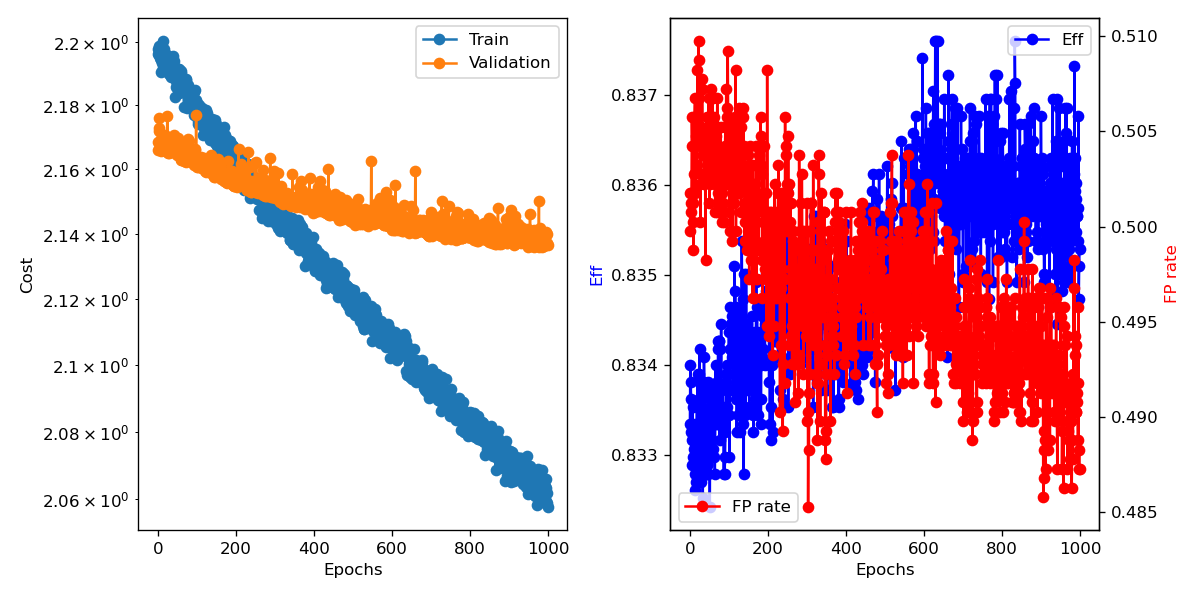

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [1]:
torch.cuda.empty_cache()"
##quit()

